In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import math

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.figure_factory import create_table

from sklearn.linear_model import RidgeCV, Lasso, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Adagrad
from sklearn.preprocessing import MinMaxScaler

In [2]:
from utils.helper import get_news_scores, add_pct_changes, print_permutation_importance, add_indicators_finta, reg_model_metrics, get_complexity, mean_squared_error

### Data Preparation

In [3]:
df_stocks = pd.read_csv('data/jpm_bars_2024-03-06.csv')

In [4]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)

In [5]:
df_stocks.tail()

open    high     low   close     volume  trade_count        vwap
date                                                                          
2024-02-28  183.43  185.20  182.96  184.38  6131608.0      90914.0  184.413387
2024-02-29  185.66  186.43  183.85  186.06  9642256.0     100032.0  185.571020
2024-03-01  185.70  186.44  185.10  185.29  6311997.0      93783.0  185.490087
2024-03-04  184.71  187.59  184.27  186.68  7062259.0     113106.0  186.647544
2024-03-05  186.36  189.30  186.36  188.55  6618615.0     109782.0  188.315997

### Engineering Features

In [6]:
#Add percent(%) changes features to stock dataframe
df_stocks = add_pct_changes(df_stocks)

In [7]:
df_stocks.tail()

open    high     low   close     volume  trade_count  \
date                                                                 
2024-02-28  183.43  185.20  182.96  184.38  6131608.0      90914.0   
2024-02-29  185.66  186.43  183.85  186.06  9642256.0     100032.0   
2024-03-01  185.70  186.44  185.10  185.29  6311997.0      93783.0   
2024-03-04  184.71  187.59  184.27  186.68  7062259.0     113106.0   
2024-03-05  186.36  189.30  186.36  188.55  6618615.0     109782.0   

                  vwap    HL_PCT  PCT_change  
date                                          
2024-02-28  184.413387  1.214882    0.517909  
2024-02-29  185.571020  1.386649    0.215448  
2024-03-01  185.490087  0.723191   -0.220786  
2024-03-04  186.647544  1.778444    1.066537  
2024-03-05  188.315997  1.559268    1.175145

In [8]:
#Add Indicators features to stock dataframe
df_stocks_full = add_indicators_finta(df_stocks)

In [9]:
df_stocks_full.head()

open    high    low  close      volume  trade_count       vwap  \
date                                                                          
2016-01-04  63.95  64.060  63.01  63.62  27827227.0     145804.0  63.451452   
2016-01-05  63.69  64.130  63.04  63.73  17591872.0     103027.0  63.519312   
2016-01-06  62.70  63.125  62.34  62.81  24407202.0     124497.0  62.745693   
2016-01-07  61.46  62.000  60.08  60.27  29310297.0     166584.0  60.834008   
2016-01-08  61.13  61.270  58.85  58.92  24651311.0     135242.0  59.791316   

              HL_PCT  PCT_change  SMM_9_period_SMM  ...  PPO_SIGNAL  \
date                                                ...               
2016-01-04  1.650424   -0.516028               NaN  ...    0.000000   
2016-01-05  1.710340    0.062804               NaN  ...    0.002153   
2016-01-06  1.249801    0.175439               NaN  ...   -0.015147   
2016-01-07  3.185665   -1.936219               NaN  ...   -0.080008   
2016-01-08  4.107264   -3.615246               NaN  ...   -0.170295   

            PPO_HISTO  VW_MACD_MACD  VW_MACD_SIGNAL  EV_MACD_MACD  \
date                                                                
2016-01-04   0.000000      0.000000        0.000000           0.0   
2016-01-05   0.001723      0.002408        0.001338           0.0   
2016-01-06  -0.024913     -0.027708       -0.010566           0.0   
2016-01-07  -0.126609     -0.140479       -0.054575           0.0   
2016-01-08  -0.213221     -0.233381       -0.107766           0.0   

            EV_MACD_SIGNAL  MOM_MOM  ROC_ROC  RSI_14_period_RSI  \
date                                                              
2016-01-04             0.0      NaN      NaN                NaN   
2016-01-05             0.0      NaN      NaN         100.000000   
2016-01-06             0.0      NaN      NaN           9.993012   
2016-01-07             0.0      NaN      NaN           2.718353   
2016-01-08             0.0      NaN      NaN           1.918821   

            IFT_RSI_IFT_RSI  
date                         
2016-01-04              NaN  
2016-01-05              NaN  
2016-01-06              NaN  
2016-01-07              NaN  
2016-01-08              NaN  

[5 rows x 36 columns]

In [10]:
# Fill the NaNs values with median values of corresponding the pandas series, as those features are skewed 
for column in df_stocks_full.columns:
    df_stocks_full[column] = df_stocks_full[column].fillna(df_stocks_full[column].median())

In [11]:
# Check for NaNs
df_stocks_full.isnull().values.any()

False

In [12]:
df_stocks_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2056 entries, 2016-01-04 to 2024-03-05
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    2056 non-null   float64
 1   high                    2056 non-null   float64
 2   low                     2056 non-null   float64
 3   close                   2056 non-null   float64
 4   volume                  2056 non-null   float64
 5   trade_count             2056 non-null   float64
 6   vwap                    2056 non-null   float64
 7   HL_PCT                  2056 non-null   float64
 8   PCT_change              2056 non-null   float64
 9   SMM_9_period_SMM        2056 non-null   float64
 10  SSMA_9_period_SSMA      2056 non-null   float64
 11  EMA_9_period_EMA        2056 non-null   float64
 12  DEMA_9_period_DEMA      2056 non-null   float64
 13  TEMA_9_period_TEMA      2056 non-null   float64
 14  TRIX_20_period_TRIX     2056 n

In [13]:
df_news = pd.read_csv('data/jpm_news_2024-03-06.csv')

In [14]:
df_news.drop(['Unnamed: 0', 'updated_at'], axis=1, inplace=True)
df_news['created_at'] = df_news.created_at.apply(lambda x: x.split(' ')[0])
df_news.rename(columns={'created_at': 'date'}, inplace=True)
df_news = df_news.sort_values('date', ascending=True)
df_news.set_index('date', inplace=True)

In [15]:
df_news.tail()

headline  \
date                                                            
2024-02-29  Peering Into JPMorgan Chase's Recent Short Int...   
2024-03-03  El Salvador's Pro-Bitcoin President Questions ...   
2024-03-04  JPMorgan's Neovest Expands Hedge Fund Horizons...   
2024-03-04  JPMorgan Aims for $1.5B in AI Value by 2023, B...   
2024-03-05  JP Morgan's Challenge To Visa And Mastercard? ...   

                                                      summary  \
date                                                            
2024-02-29                                                      
2024-03-03  The week was peppered with crucial financial u...   
2024-03-04  JPMorgan&#39;s subsidiary Neovest acquires Lay...   
2024-03-04  JPMorgan&#39;s AI-powered tool, Cash Flow Inte...   
2024-03-05  JP Morgan&#39;s partnership with Cartes Bancai...   

                                                          url news_type  \
date                                                                      
2024-02-29  https://www.benzinga.com/insights/short-seller...   neutral   
2024-03-03  https://www.benzinga.com/news/24/03/37443990/e...  positive   
2024-03-04  https://www.benzinga.com/markets/equities/24/0...   neutral   
2024-03-04  https://www.benzinga.com/news/24/03/37464248/j...   neutral   
2024-03-05  https://www.benzinga.com/markets/equities/24/0...  positive   

               score                                   symbols  
date                                                            
2024-02-29  0.999364                                   ['JPM']  
2024-03-03  0.988096                                   ['JPM']  
2024-03-04  0.952559                                   ['JPM']  
2024-03-04  0.998656  ['C', 'GS', 'JEPI', 'JPM', 'JPST', 'MS']  
2024-03-05  0.833253                        ['JPM', 'MA', 'V']

In [16]:
df_news['news_type'].value_counts()

neutral     3759
positive     597
negative     116
Name: news_type, dtype: int64

In [17]:
# Getting the news scores regarding the stock
df_score = get_news_scores(df = df_news)

In [18]:
df_score.tail()

score news_type
date                          
2024-02-28  0.999356   neutral
2024-02-29  0.999420   neutral
2024-03-03  0.988096  positive
2024-03-04  0.975608   neutral
2024-03-05  0.833253  positive

In [19]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1744 entries, 2015-01-02 to 2024-03-05
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1744 non-null   float64
 1   news_type  1744 non-null   object 
dtypes: float64(1), object(1)
memory usage: 40.9+ KB


In [20]:
# Check for NaNs
df_score.isnull().values.any()

False

In [21]:
df_score.shape[0], df_stocks_full.shape[0]

(1744, 2056)

In [22]:
# Adding news scores to stock dataframe
df = df_stocks_full.join(df_score, how='left', on='date')

In [23]:
df.tail()

open    high     low   close     volume  trade_count  \
date                                                                 
2024-02-28  183.43  185.20  182.96  184.38  6131608.0      90914.0   
2024-02-29  185.66  186.43  183.85  186.06  9642256.0     100032.0   
2024-03-01  185.70  186.44  185.10  185.29  6311997.0      93783.0   
2024-03-04  184.71  187.59  184.27  186.68  7062259.0     113106.0   
2024-03-05  186.36  189.30  186.36  188.55  6618615.0     109782.0   

                  vwap    HL_PCT  PCT_change  SMM_9_period_SMM  ...  \
date                                                            ...   
2024-02-28  184.413387  1.214882    0.517909            183.07  ...   
2024-02-29  185.571020  1.386649    0.215448            183.36  ...   
2024-03-01  185.490087  0.723191   -0.220786            183.45  ...   
2024-03-04  186.647544  1.778444    1.066537            183.99  ...   
2024-03-05  188.315997  1.559268    1.175145            184.38  ...   

            VW_MACD_MACD  VW_MACD_SIGNAL  EV_MACD_MACD  EV_MACD_SIGNAL  \
date                                                                     
2024-02-28      3.838741        3.321434      7.036275        6.552748   
2024-02-29      4.083896        3.473926      7.297253        6.701649   
2024-03-01      4.111603        3.601461      7.433047        6.847929   
2024-03-04      4.214693        3.724108      7.609379        7.000219   
2024-03-05      4.401400        3.859566      7.807197        7.161614   

            MOM_MOM   ROC_ROC  RSI_14_period_RSI  IFT_RSI_IFT_RSI     score  \
date                                                                          
2024-02-28    10.12  5.353980          75.307487         0.809908  0.999356   
2024-02-29    10.03  5.842198          77.917784         0.826768  0.999420   
2024-03-01     5.42  6.329622          74.053777         0.815206       NaN   
2024-03-04     7.65  6.050105          76.335234         0.815627  0.975608   
2024-03-05     8.82  4.825707          79.009324         0.825875  0.833253   

            news_type  
date                   
2024-02-28    neutral  
2024-02-29    neutral  
2024-03-01        NaN  
2024-03-04    neutral  
2024-03-05   positive  

[5 rows x 38 columns]

In [24]:
score_mean = df.query('news_type=="neutral"')['score'].mean()
df['score'].fillna(score_mean, inplace=True)
df.rename(columns={'score': 'news_score'}, inplace=True)
df['news_type'].fillna('neutral', inplace=True)

In [25]:
df.head()

open    high    low  close      volume  trade_count       vwap  \
date                                                                          
2016-01-04  63.95  64.060  63.01  63.62  27827227.0     145804.0  63.451452   
2016-01-05  63.69  64.130  63.04  63.73  17591872.0     103027.0  63.519312   
2016-01-06  62.70  63.125  62.34  62.81  24407202.0     124497.0  62.745693   
2016-01-07  61.46  62.000  60.08  60.27  29310297.0     166584.0  60.834008   
2016-01-08  61.13  61.270  58.85  58.92  24651311.0     135242.0  59.791316   

              HL_PCT  PCT_change  SMM_9_period_SMM  ...  VW_MACD_MACD  \
date                                                ...                 
2016-01-04  1.650424   -0.516028            114.18  ...      0.000000   
2016-01-05  1.710340    0.062804            114.18  ...      0.002408   
2016-01-06  1.249801    0.175439            114.18  ...     -0.027708   
2016-01-07  3.185665   -1.936219            114.18  ...     -0.140479   
2016-01-08  4.107264   -3.615246            114.18  ...     -0.233381   

            VW_MACD_SIGNAL  EV_MACD_MACD  EV_MACD_SIGNAL  MOM_MOM   ROC_ROC  \
date                                                                          
2016-01-04        0.000000           0.0             0.0    0.815  1.002157   
2016-01-05        0.001338           0.0             0.0    0.815  1.002157   
2016-01-06       -0.010566           0.0             0.0    0.815  1.002157   
2016-01-07       -0.054575           0.0             0.0    0.815  1.002157   
2016-01-08       -0.107766           0.0             0.0    0.815  1.002157   

            RSI_14_period_RSI  IFT_RSI_IFT_RSI  news_score  news_type  
date                                                                   
2016-01-04          53.372179         0.200679    0.999299    neutral  
2016-01-05         100.000000         0.200679    0.999413    neutral  
2016-01-06           9.993012         0.200679    0.999304    neutral  
2016-01-07           2.718353         0.200679    0.999489    neutral  
2016-01-08           1.918821         0.200679    0.999463    neutral  

[5 rows x 38 columns]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2056 entries, 2016-01-04 to 2024-03-05
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    2056 non-null   float64
 1   high                    2056 non-null   float64
 2   low                     2056 non-null   float64
 3   close                   2056 non-null   float64
 4   volume                  2056 non-null   float64
 5   trade_count             2056 non-null   float64
 6   vwap                    2056 non-null   float64
 7   HL_PCT                  2056 non-null   float64
 8   PCT_change              2056 non-null   float64
 9   SMM_9_period_SMM        2056 non-null   float64
 10  SSMA_9_period_SSMA      2056 non-null   float64
 11  EMA_9_period_EMA        2056 non-null   float64
 12  DEMA_9_period_DEMA      2056 non-null   float64
 13  TEMA_9_period_TEMA      2056 non-null   float64
 14  TRIX_20_period_TRIX     2056 n

In [27]:
#converting the news_type feature to binary type, POSITIVE = 2 and NEGATIVE = 0, also NEUTRAL = 1
df['news_type'] = df['news_type'].apply(lambda x:2 if x in ['positive'] else (0 if x in ['negative'] else 1))

In [28]:
df['news_type'].value_counts()

1    1671
2     373
0      12
Name: news_type, dtype: int64

In [29]:
df.describe()

open         high          low        close        volume  \
count  2056.000000  2056.000000  2056.000000  2056.000000  2.056000e+03   
mean    115.815654   116.913205   114.735637   115.837534  1.556387e+07   
std      29.742698    29.968864    29.532778    29.764900  7.411793e+06   
min      53.910000    53.910000    52.500000    53.070000  1.604000e+05   
25%      95.997500    97.437500    95.005000    96.270000  1.074952e+07   
50%     113.545000   114.680000   112.705000   113.710000  1.401121e+07   
75%     138.692500   139.987500   137.667500   138.747500  1.791947e+07   
max     186.360000   189.300000   186.360000   188.550000  7.290765e+07   

         trade_count         vwap       HL_PCT   PCT_change  SMM_9_period_SMM  \
count    2056.000000  2056.000000  2056.000000  2056.000000       2056.000000   
mean   114037.901265   115.833663     1.899925     0.025322        115.836561   
std     53126.533369    29.757394     1.175034     1.248546         29.468958   
min         1.000000    53.284123     0.411324    -5.234433         57.010000   
25%     79584.250000    96.323633     1.182838    -0.600812         96.830000   
50%    101969.500000   113.722538     1.612024     0.051617        114.180000   
75%    131262.500000   138.755411     2.259988     0.670908        138.450000   
max    457367.000000   188.315997    13.130129     8.250859        184.380000   

       ...  VW_MACD_MACD  VW_MACD_SIGNAL  EV_MACD_MACD  EV_MACD_SIGNAL  \
count  ...   2056.000000     2056.000000   2056.000000     2056.000000   
mean   ...      0.539456        0.531728      2.433290        2.419531   
std    ...      1.902418        1.772514      5.980376        5.910056   
min    ...     -7.296078       -6.473392     -7.789779       -7.692935   
25%    ...     -0.565521       -0.498370     -0.138631       -0.092449   
50%    ...      0.587087        0.573849      1.678584        1.639620   
75%    ...      1.676530        1.577709      4.220361        4.131000   
max    ...      5.740988        5.292522     35.513405       33.707684   

           MOM_MOM      ROC_ROC  RSI_14_period_RSI  IFT_RSI_IFT_RSI  \
count  2056.000000  2056.000000        2056.000000      2056.000000   
mean      0.610000     0.832200          53.793879         0.053611   
std       6.111746     5.666866          12.640521         0.608353   
min     -38.720000   -32.038694           1.879140        -1.000000   
25%      -2.190000    -2.144817          45.330588        -0.482423   
50%       0.815000     1.002157          53.372179         0.200679   
75%       3.970000     3.911296          62.964802         0.607141   
max      23.980000    25.442653         100.000000         0.891388   

        news_score    news_type  
count  2056.000000  2056.000000  
mean      0.989135     1.175584  
std       0.045074     0.395605  
min       0.427322     0.000000  
25%       0.994821     1.000000  
50%       0.999251     1.000000  
75%       0.999452     1.000000  
max       0.999706     2.000000  

[8 rows x 38 columns]

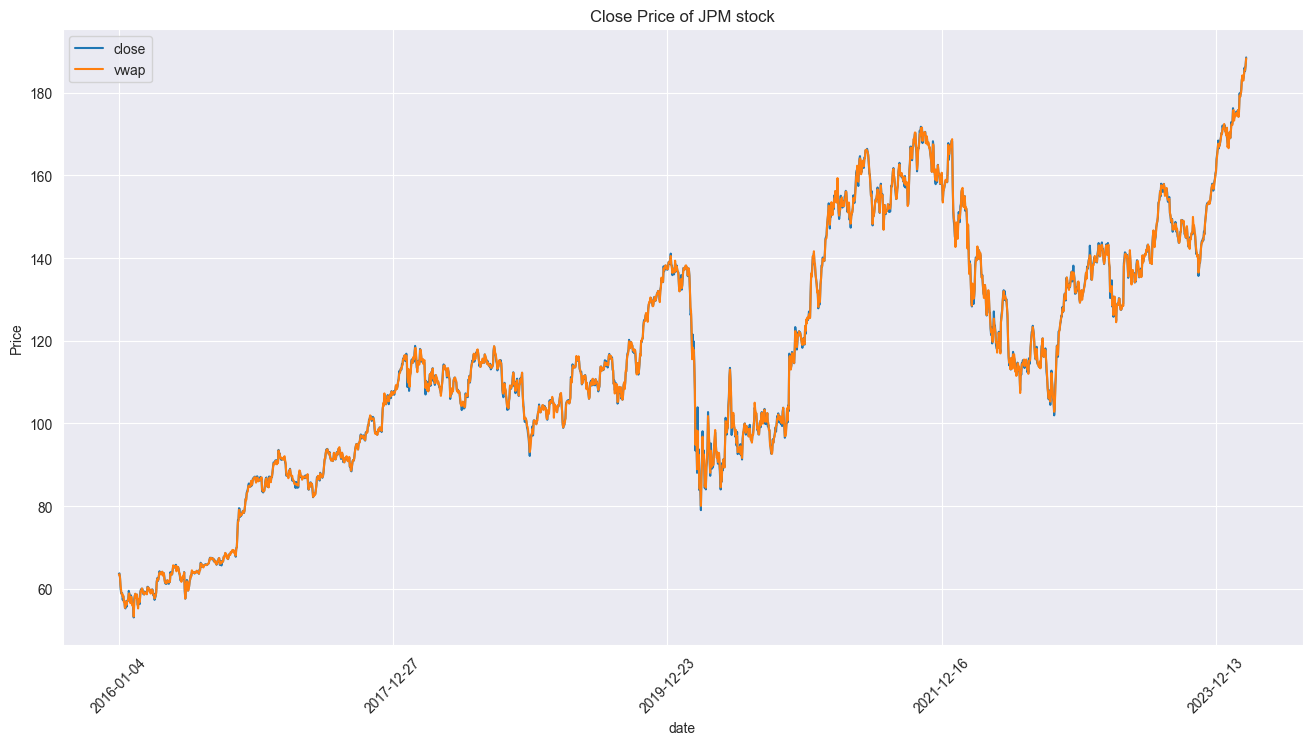

In [30]:
plt.figure(figsize=(16,8))
df['close'].plot(kind='line')
df['vwap'].plot(kind='line')
plt.xticks(rotation = 45)
plt.title('Close Price of JPM stock')
plt.ylabel('Price')
plt.legend()
plt.show()


##### The 'vwap' is a feature variable which is an independent, and 'close' price is the target, which is a dependent variable (explainable).  

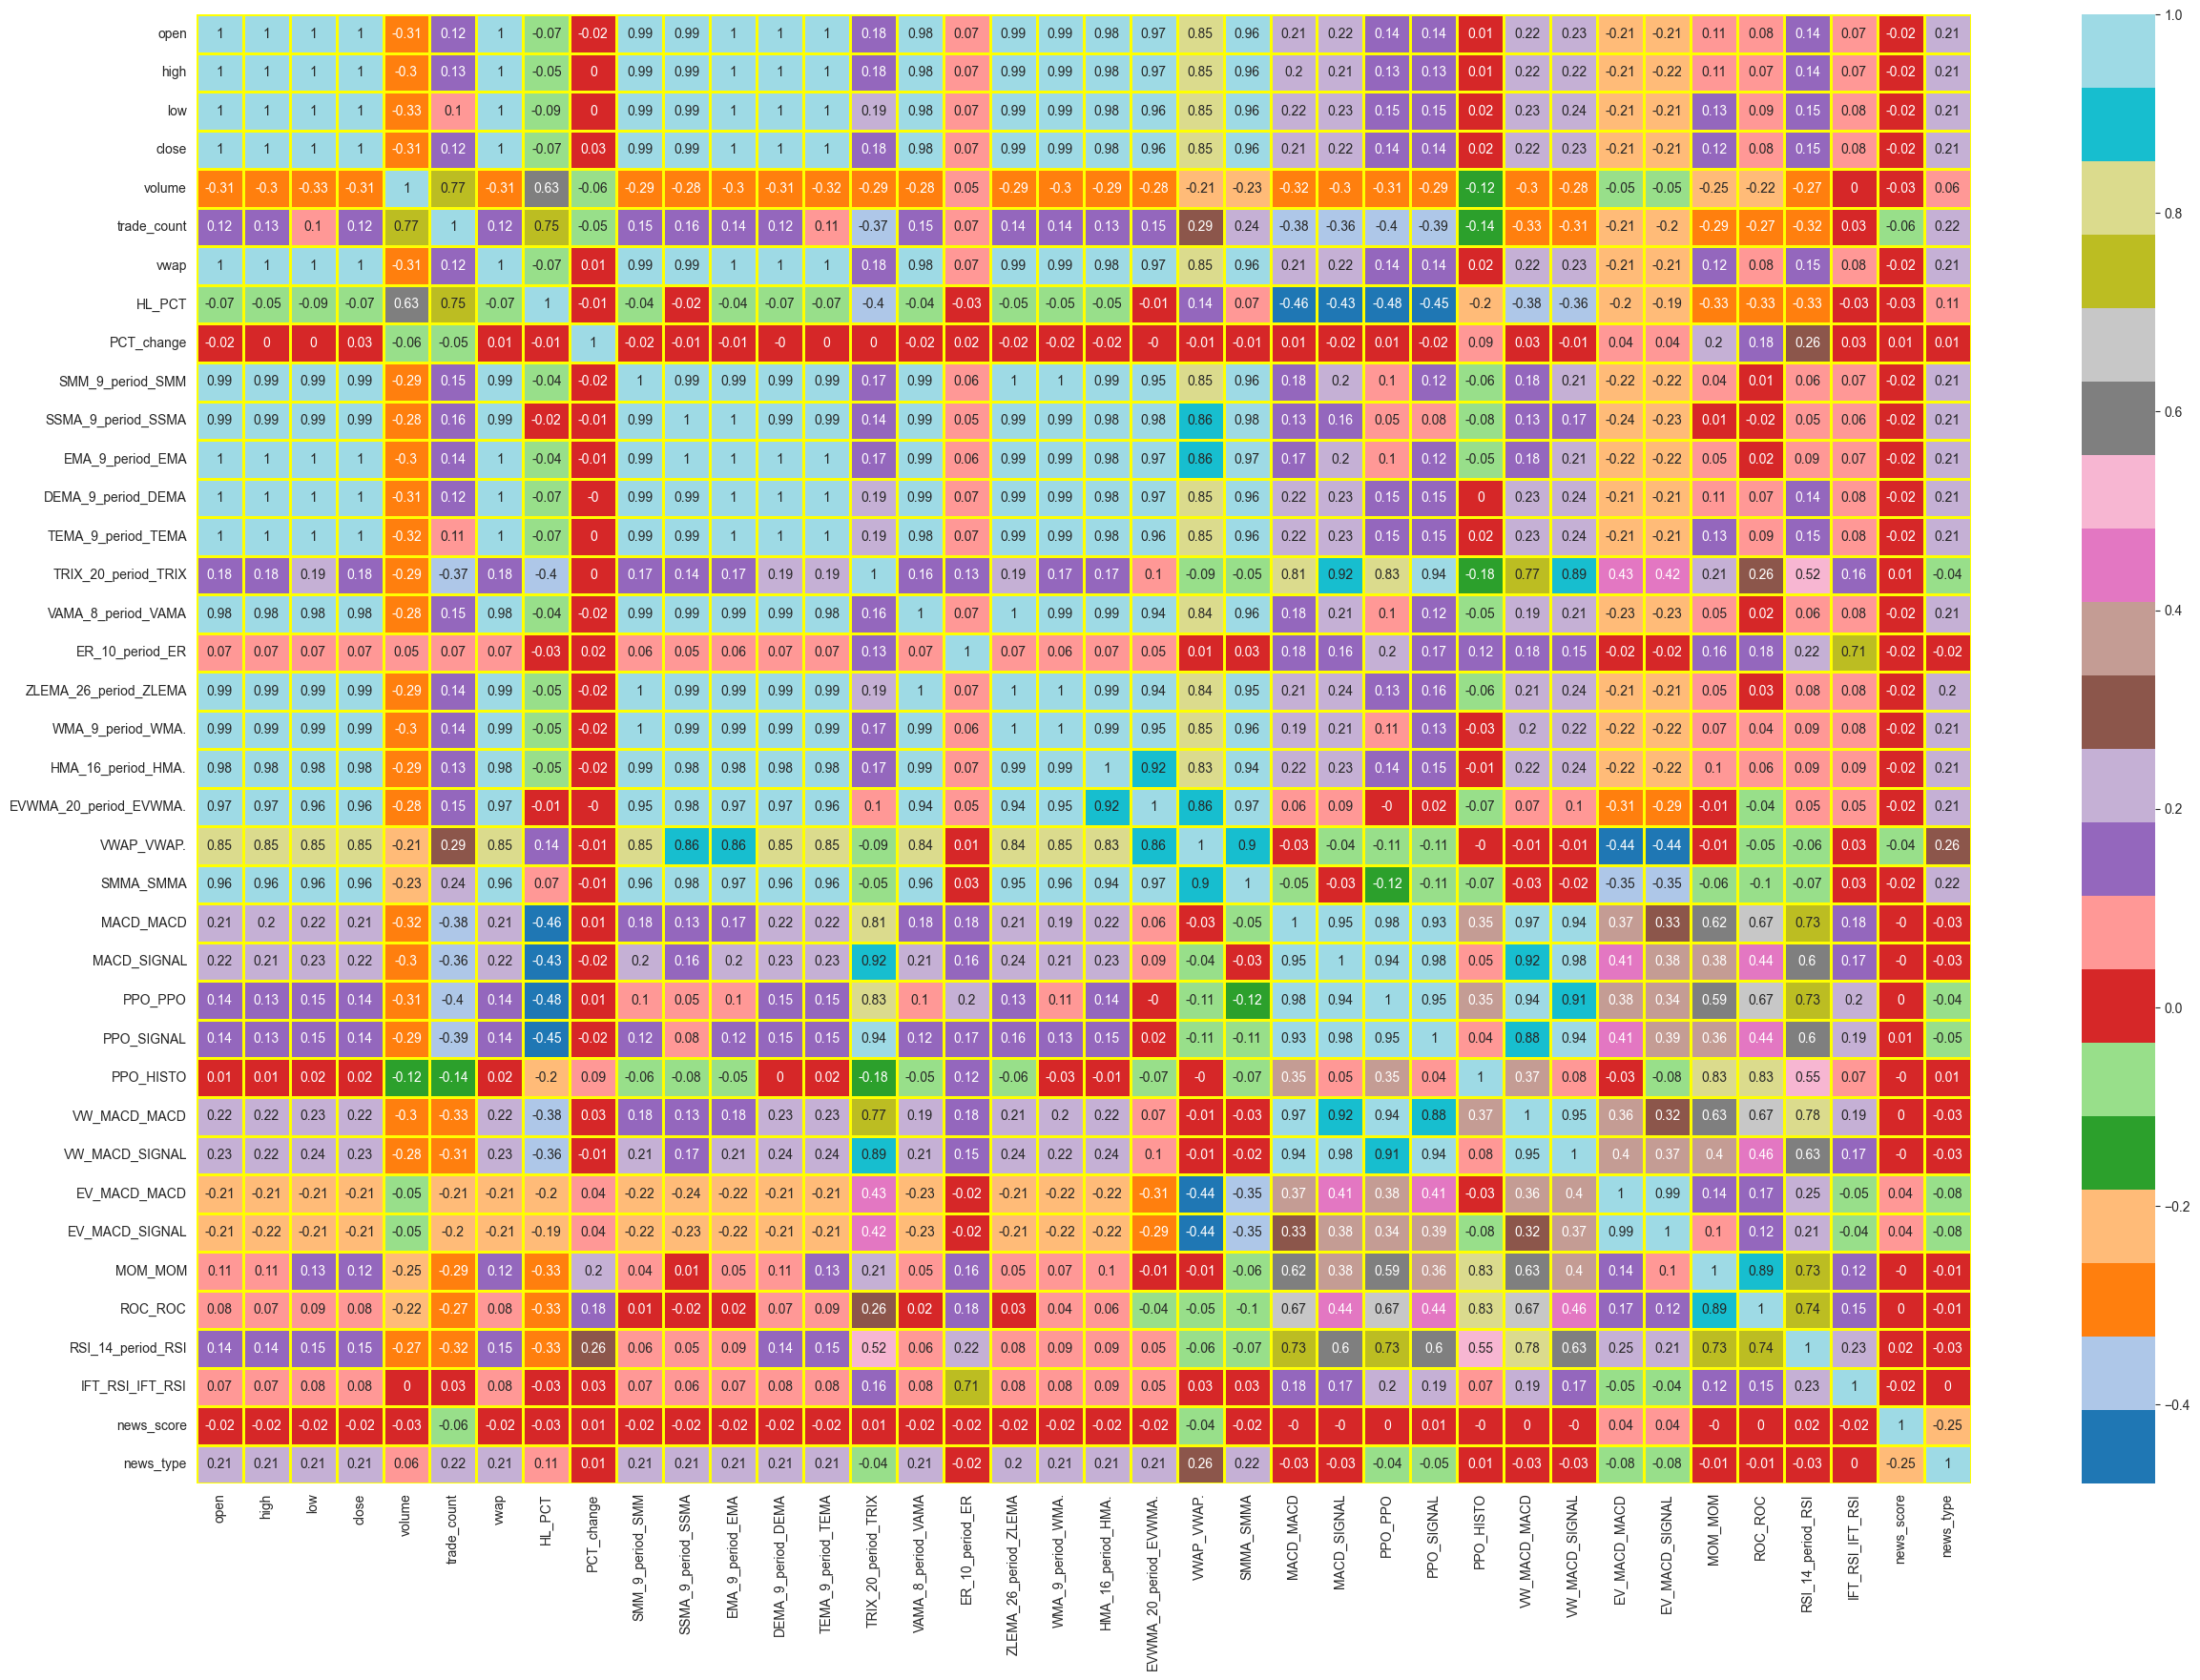

In [31]:
corr =df.corr()
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
sns.heatmap(corr.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [32]:
corr_matrix = pd.DataFrame(corr)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

#### Removing highly correlated features, and to the 'close' price, which is the target feature

In [33]:
corr_matrix['close'].sort_values(ascending=False).to_frame().index

Index(['open', 'TEMA_9_period_TEMA', 'low', 'close', 'high', 'vwap',
       'EMA_9_period_EMA', 'DEMA_9_period_DEMA', 'WMA_9_period_WMA.',
       'ZLEMA_26_period_ZLEMA', 'SMM_9_period_SMM', 'SSMA_9_period_SSMA',
       'VAMA_8_period_VAMA', 'HMA_16_period_HMA.', 'SMMA_SMMA',
       'EVWMA_20_period_EVWMA.', 'VWAP_VWAP.', 'VW_MACD_SIGNAL',
       'VW_MACD_MACD', 'MACD_SIGNAL', 'news_type', 'MACD_MACD',
       'TRIX_20_period_TRIX', 'RSI_14_period_RSI', 'PPO_PPO', 'PPO_SIGNAL',
       'trade_count', 'MOM_MOM', 'ROC_ROC', 'IFT_RSI_IFT_RSI',
       'ER_10_period_ER', 'PCT_change', 'PPO_HISTO', 'news_score', 'HL_PCT',
       'EV_MACD_MACD', 'EV_MACD_SIGNAL', 'volume'],
      dtype='object')

In [34]:
low_corr_columns = ['close', 'news_type', 'MACD_MACD',  # 'VWAP_VWAP.'
                    'TRIX_20_period_TRIX', 'RSI_14_period_RSI', 'news_score', 'PPO_PPO',
                    'trade_count', 'MOM_MOM', 'ROC_ROC', 'IFT_RSI_IFT_RSI',
                    'ER_10_period_ER', 'PCT_change', 'PPO_HISTO', 'HL_PCT', 'EV_MACD_MACD', 'EV_MACD_SIGNAL', 'volume'] 

In [35]:
df_corr  = df[low_corr_columns]

<Axes: >

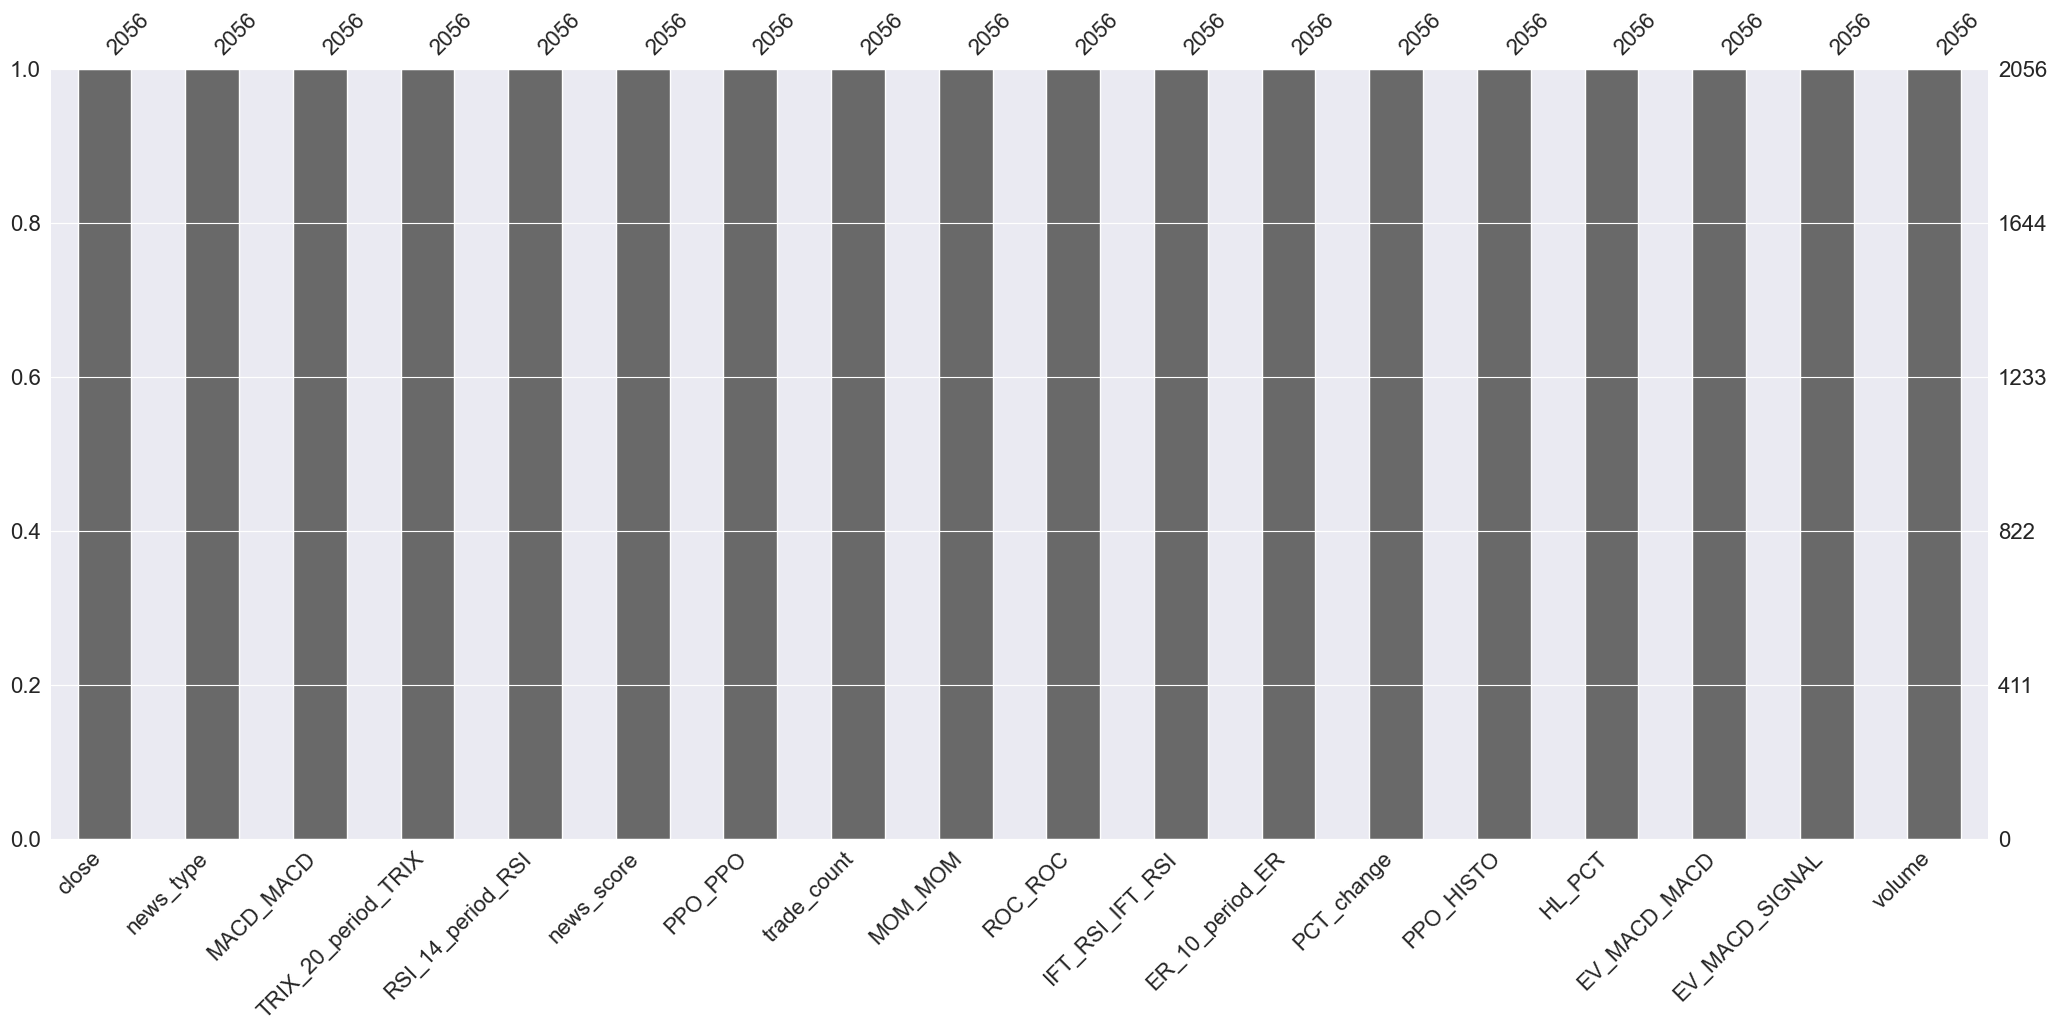

In [36]:
msno.bar(df_corr)

In [37]:
df_corr.tail()

close  news_type  MACD_MACD  TRIX_20_period_TRIX  \
date                                                            
2024-02-28  184.38          1   3.476674             0.230120   
2024-02-29  186.06          1   3.632157             0.235373   
2024-03-01  185.29          1   3.651157             0.240345   
2024-03-04  186.68          1   3.735318             0.245452   
2024-03-05  188.55          2   3.907862             0.251226   

            RSI_14_period_RSI  news_score   PPO_PPO  trade_count  MOM_MOM  \
date                                                                        
2024-02-28          75.307487    0.999356  1.959729      90914.0    10.12   
2024-02-29          77.917784    0.999420  2.040000     100032.0    10.03   
2024-03-01          74.053777    0.994821  2.044510      93783.0     5.42   
2024-03-04          76.335234    0.975608  2.084636     113106.0     7.65   
2024-03-05          79.009324    0.833253  2.172518     109782.0     8.82   

             ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  PCT_change  PPO_HISTO  \
date                                                                            
2024-02-28  5.353980         0.809908         0.774885    0.517909   0.233759   
2024-02-29  5.842198         0.826768         0.773323    0.215448   0.251224   
2024-03-01  6.329622         0.815206         0.547475   -0.220786   0.204588   
2024-03-04  6.050105         0.815627         0.732057    1.066537   0.195771   
2024-03-05  4.825707         0.825875         0.759036    1.175145   0.226923   

              HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL     volume  
date                                                           
2024-02-28  1.214882      7.036275        6.552748  6131608.0  
2024-02-29  1.386649      7.297253        6.701649  9642256.0  
2024-03-01  0.723191      7.433047        6.847929  6311997.0  
2024-03-04  1.778444      7.609379        7.000219  7062259.0  
2024-03-05  1.559268      7.807197        7.161614  6618615.0

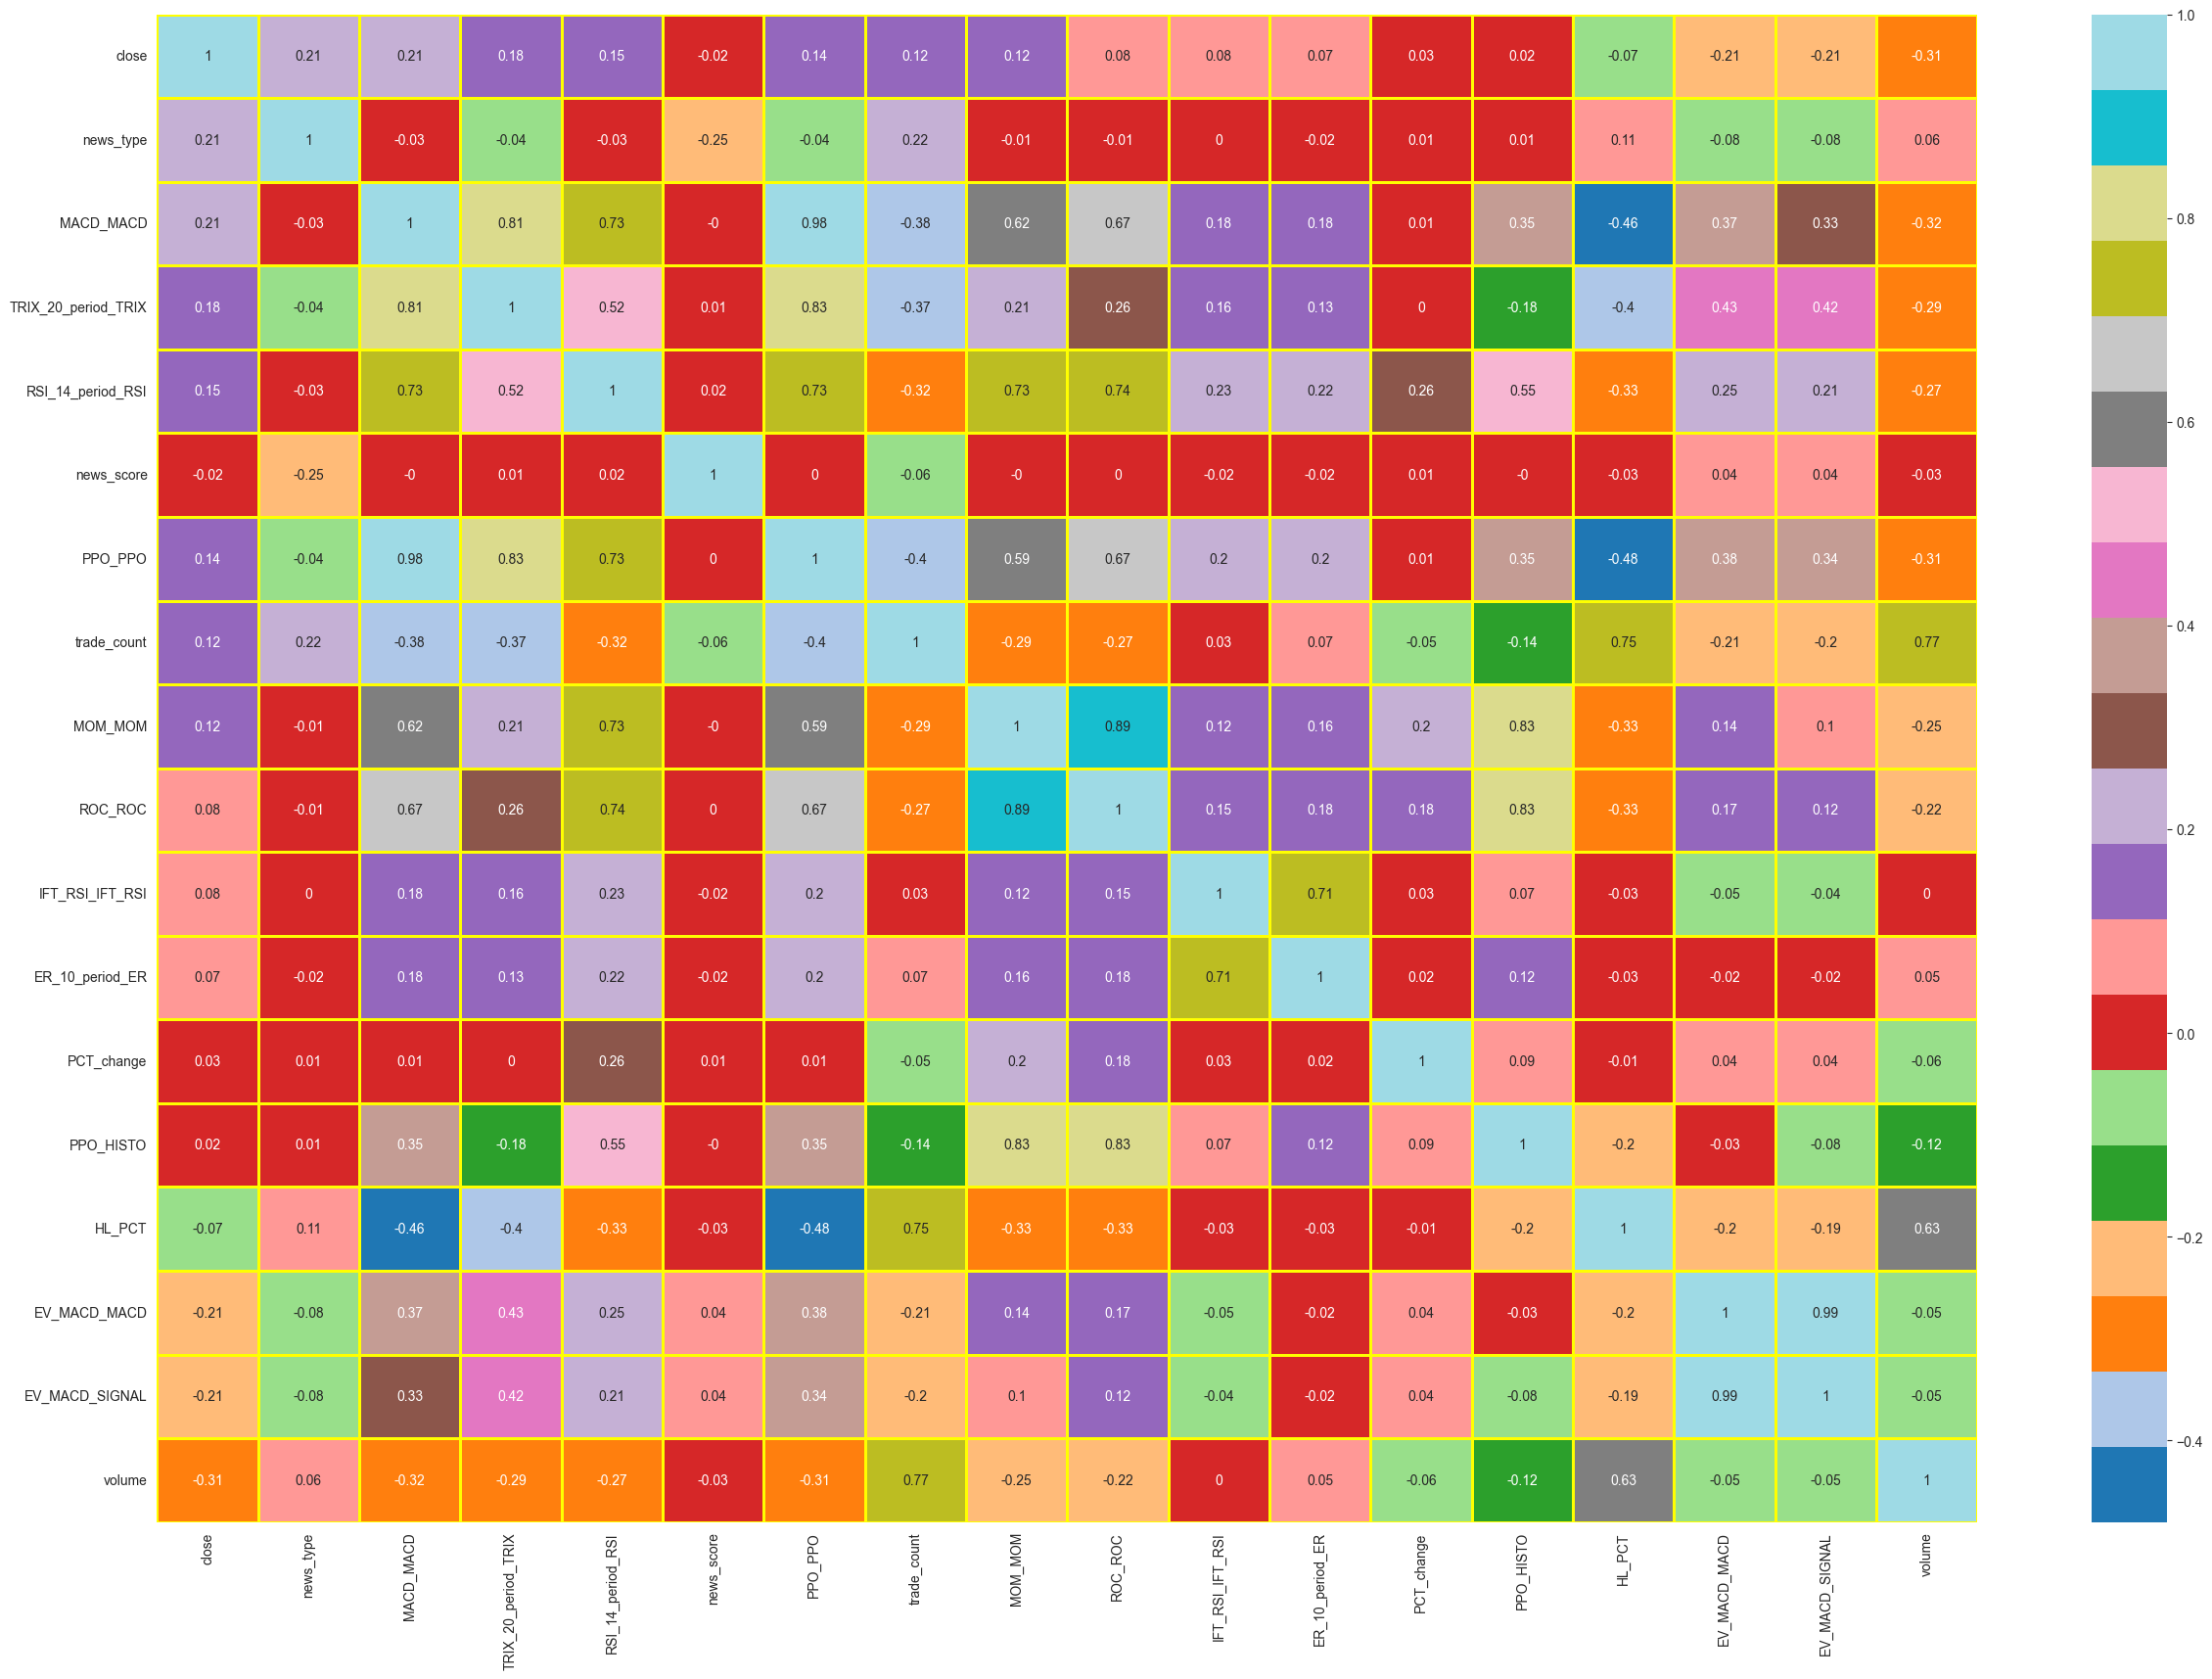

In [38]:
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
corr_low =df_corr.corr()
sns.heatmap(corr_low.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [39]:
# Correlations to the Target feature 'close'
corr_matrix = pd.DataFrame(corr_low)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

In [40]:
df_corr.describe()

close    news_type    MACD_MACD  TRIX_20_period_TRIX  \
count  2056.000000  2056.000000  2056.000000          2056.000000   
mean    115.837534     1.175584     0.400423             0.048216   
std      29.764900     0.395605     2.125809             0.216807   
min      53.070000     0.000000   -12.509386            -1.037542   
25%      96.270000     1.000000    -0.624093            -0.069956   
50%     113.710000     1.000000     0.474396             0.067806   
75%     138.747500     1.000000     1.631527             0.171248   
max     188.550000     2.000000     5.649333             0.531040   

       RSI_14_period_RSI   news_score      PPO_PPO    trade_count  \
count        2056.000000  2056.000000  2056.000000    2056.000000   
mean           53.793879     0.989135     0.343843  114037.901265   
std            12.640521     0.045074     1.811251   53126.533369   
min             1.879140     0.427322   -11.864494       1.000000   
25%            45.330588     0.994821    -0.572552   79584.250000   
50%            53.372179     0.999251     0.509266  101969.500000   
75%            62.964802     0.999452     1.370460  131262.500000   
max           100.000000     0.999706     4.806173  457367.000000   

           MOM_MOM      ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  \
count  2056.000000  2056.000000      2056.000000      2056.000000   
mean      0.610000     0.832200         0.053611         0.342824   
std       6.111746     5.666866         0.608353         0.232774   
min     -38.720000   -32.038694        -1.000000         0.000000   
25%      -2.190000    -2.144817        -0.482423         0.147700   
50%       0.815000     1.002157         0.200679         0.309895   
75%       3.970000     3.911296         0.607141         0.509031   
max      23.980000    25.442653         0.891388         1.000000   

        PCT_change    PPO_HISTO       HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL  \
count  2056.000000  2056.000000  2056.000000   2056.000000     2056.000000   
mean      0.025322     0.004162     1.899925      2.433290        2.419531   
std       1.248546     0.555764     1.175034      5.980376        5.910056   
min      -5.234433    -3.149239     0.411324     -7.789779       -7.692935   
25%      -0.600812    -0.292865     1.182838     -0.138631       -0.092449   
50%       0.051617    -0.003487     1.612024      1.678584        1.639620   
75%       0.670908     0.293002     2.259988      4.220361        4.131000   
max       8.250859     2.693997    13.130129     35.513405       33.707684   

             volume  
count  2.056000e+03  
mean   1.556387e+07  
std    7.411793e+06  
min    1.604000e+05  
25%    1.074952e+07  
50%    1.401121e+07  
75%    1.791947e+07  
max    7.290765e+07

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'news_type'}>,
        <Axes: title={'center': 'MACD_MACD'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'news_score'}>,
        <Axes: title={'center': 'PPO_PPO'}>,
        <Axes: title={'center': 'trade_count'}>],
       [<Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'ER_10_period_ER'}>],
       [<Axes: title={'center': 'PCT_change'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'HL_PCT'}>,
        <Axes: title={'center': 'EV_MACD_MACD'}>],
       [<Axes: title={'center': 'EV_MACD_SIGNAL'}>,
        <Axes: title={'center': 'volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

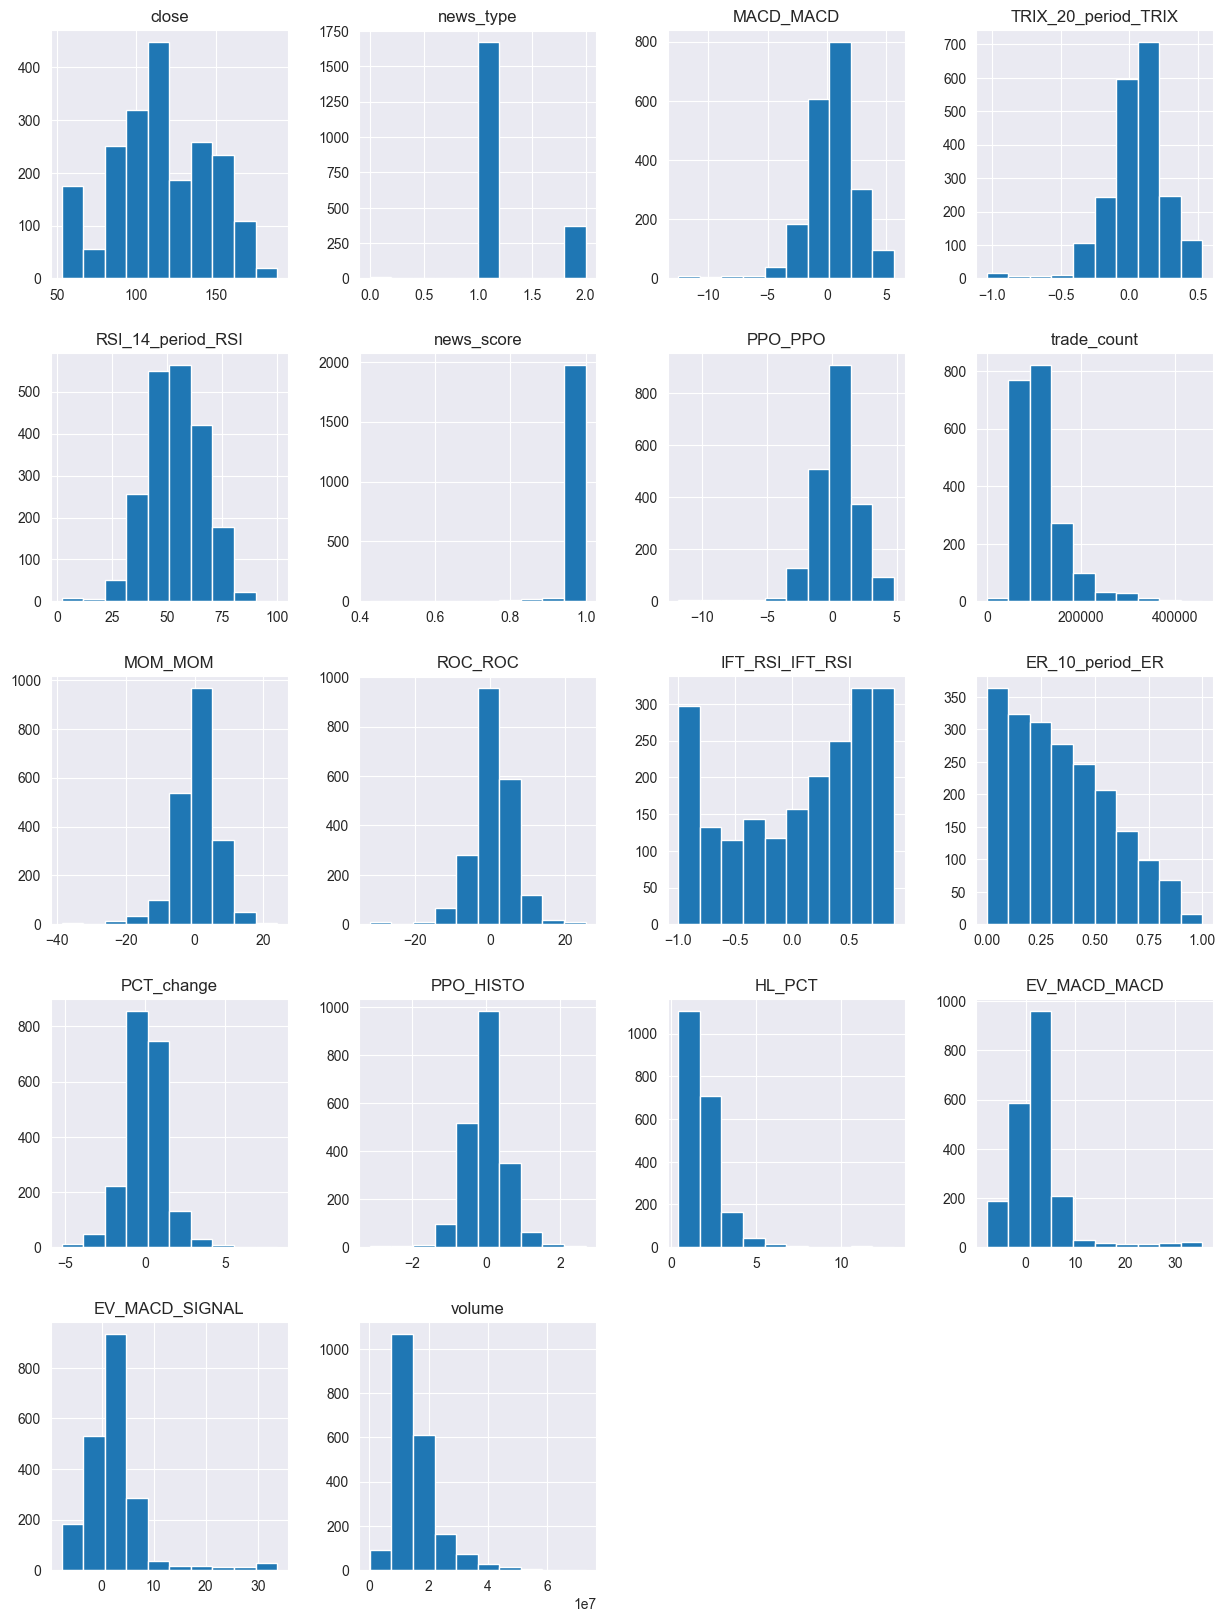

In [41]:
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_corr.hist(ax=ax)

##### from the dataframe describe mean and std are not 0 and 1, and from the histogram we can see the dataset is skewed on left and right
##### even the 'vwap' feature is highly correlated to the target, it is kept. The "Volume Weighted Average Price" is a benchmark indicator for traders

In [42]:
#Scaling dataset before Normalising it
data = df_corr.copy()
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Normalization of the dataset
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
trans_array = trans.fit_transform(df_corr)
df_norm = pd.DataFrame(trans_array)
named_columns = df_corr.columns
numer_columns = df_norm.copy().columns
tuples = [(key, value) for i, (key, value) in enumerate(zip(numer_columns, named_columns))]
columns = dict(tuples)
df_norm.rename(columns=columns, inplace=True)
df_norm = df_norm[named_columns]
df_norm.index = df.index
df_norm.describe()

close    news_type    MACD_MACD  TRIX_20_period_TRIX  \
count  2056.000000  2056.000000  2056.000000          2056.000000   
mean      0.000030     0.731978     0.000150            -0.000134   
std       1.009352     2.137486     1.009837             1.009682   
min      -5.199338    -5.199338    -5.199338            -5.199338   
25%      -0.674377    -0.222630    -0.673926            -0.674575   
50%      -0.000418    -0.222630    -0.000518             0.000093   
75%       0.674677    -0.222630     0.675295             0.674279   
max       5.199338     5.199338     5.199338             5.199338   

       RSI_14_period_RSI   news_score      PPO_PPO  trade_count      MOM_MOM  \
count        2056.000000  2056.000000  2056.000000  2056.000000  2056.000000   
mean           -0.000419     0.009956     0.000109    -0.000558    -0.000036   
std             1.010610     0.989163     1.009708     1.011144     1.009414   
min            -5.199338    -5.199338    -5.199338    -5.199338    -5.199338   
25%            -0.674586    -0.692715    -0.675108    -0.673901    -0.674017   
50%            -0.000084    -0.000779     0.000200    -0.000206     0.000000   
75%             0.674192     0.674432     0.674939     0.674145     0.674017   
max             5.199338     5.199338     5.199338     5.199338     5.199338   

           ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER   PCT_change  \
count  2056.000000      2056.000000      2056.000000  2056.000000   
mean      0.000048        -0.000411        -0.000133     0.000107   
std       1.009492         1.010538         1.009598     1.009535   
min      -5.199338        -5.199338        -5.199338    -5.199338   
25%      -0.674660        -0.674124        -0.674461    -0.674486   
50%       0.000000         0.000000         0.000000    -0.000056   
75%       0.674697         0.674378         0.674920     0.674647   
max       5.199338         5.199338         5.199338     5.199338   

         PPO_HISTO       HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL       volume  
count  2056.000000  2056.000000   2056.000000     2056.000000  2056.000000  
mean     -0.000044    -0.000094      0.000010        0.000037    -0.000076  
std       1.009440     1.009354      1.009710        1.009693     1.009150  
min      -5.199338    -5.199338     -5.199338       -5.199338    -5.199338  
25%      -0.674330    -0.675056     -0.674066       -0.675845    -0.674077  
50%      -0.000053    -0.000521      0.000011       -0.000598    -0.000529  
75%       0.675023     0.674259      0.673954        0.674425     0.674502  
max       5.199338     5.199338      5.199338        5.199338     5.199338

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'news_type'}>,
        <Axes: title={'center': 'MACD_MACD'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'news_score'}>,
        <Axes: title={'center': 'PPO_PPO'}>,
        <Axes: title={'center': 'trade_count'}>],
       [<Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'ER_10_period_ER'}>],
       [<Axes: title={'center': 'PCT_change'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'HL_PCT'}>,
        <Axes: title={'center': 'EV_MACD_MACD'}>],
       [<Axes: title={'center': 'EV_MACD_SIGNAL'}>,
        <Axes: title={'center': 'volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

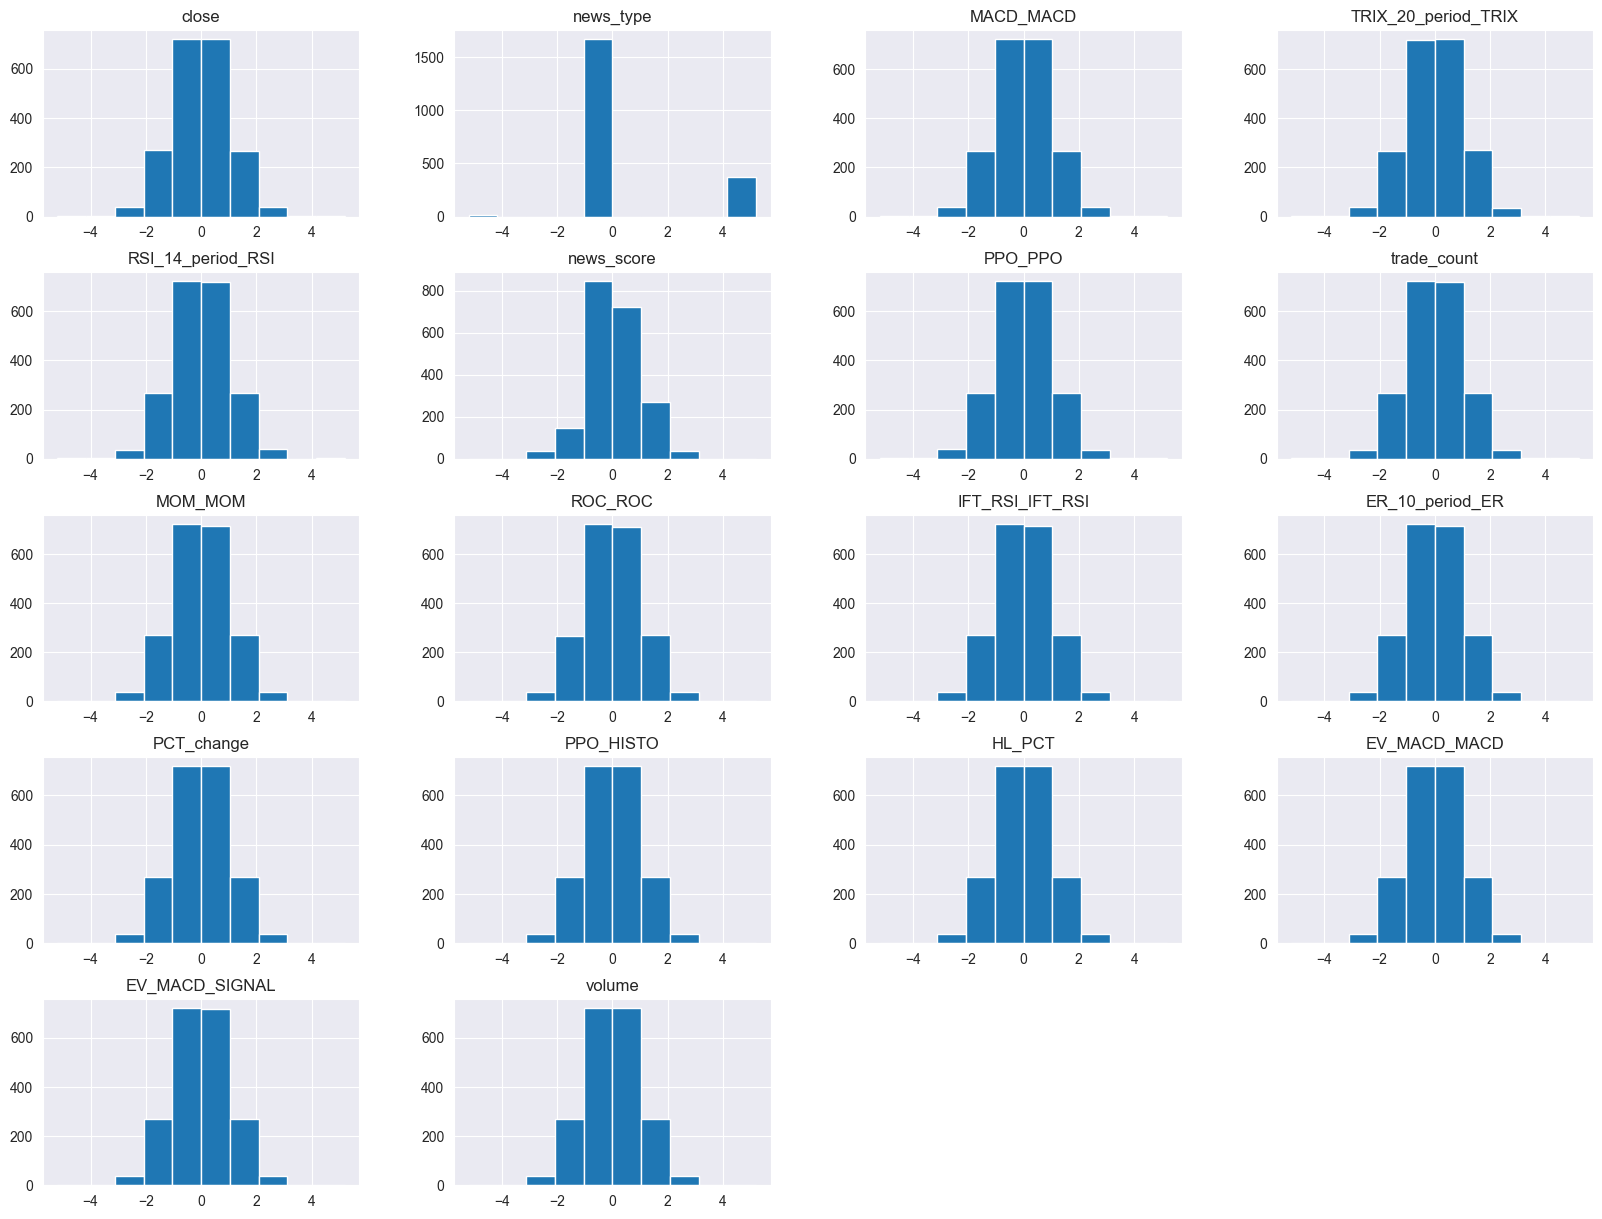

In [43]:
df_norm.hist(figsize=(20,15))

##### As we can see from the describe method of pandas DataFrame, the mean is 0 and std is 1 and from the above bell shape plots, now our dataset has a normal distribution

In [44]:
df_norm.tail()

close  news_type  MACD_MACD  TRIX_20_period_TRIX  \
date                                                              
2024-02-28  2.882049  -0.222630   1.573040             1.010760   
2024-02-29  3.095126  -0.222630   1.597992             1.025370   
2024-03-01  2.981656  -0.222630   1.612586             1.049321   
2024-03-04  3.179078  -0.222630   1.644296             1.066423   
2024-03-05  5.199338   5.199338   1.682525             1.081380   

            RSI_14_period_RSI  news_score   PPO_PPO  trade_count   MOM_MOM  \
date                                                                         
2024-02-28           1.718835    0.081638  1.087444    -0.330991  1.711592   
2024-02-29           1.960897    0.330873  1.128335    -0.034772  1.694923   
2024-03-01           1.615983   -0.692715  1.133813    -0.226417  0.907080   
2024-03-04           1.828428   -1.564763  1.158850     0.288755  1.261187   
2024-03-05           2.098998   -2.093732  1.228719     0.206994  1.454408   

             ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  PCT_change  PPO_HISTO  \
date                                                                            
2024-02-28  0.926355         1.537639         1.620016    0.510963   0.536948   
2024-02-29  1.018576         1.750635         1.608713    0.188224   0.579096   
2024-03-01  1.108589         1.588320         0.816428   -0.288770   0.467415   
2024-03-04  1.068321         1.597560         1.460681    1.060407   0.452524   
2024-03-05  0.831352         1.733083         1.551592    1.145343   0.514875   

              HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL    volume  
date                                                          
2024-02-28 -0.602818      1.379278        1.334070 -2.358390  
2024-02-29 -0.318138      1.417093        1.346689 -0.974319  
2024-03-01 -1.970540      1.435106        1.358590 -2.234694  
2024-03-04  0.210702      1.459347        1.367133 -1.860306  
2024-03-05 -0.071547      1.487816        1.377870 -2.054395

In [45]:
df_norm.head()

close  news_type  MACD_MACD  TRIX_20_period_TRIX  \
date                                                              
2016-01-04 -1.607745   -0.22263  -0.328234             0.000093   
2016-01-05 -1.594492   -0.22263  -0.325196            -0.223899   
2016-01-06 -1.668386   -0.22263  -0.347688            -0.581070   
2016-01-07 -1.837750   -0.22263  -0.409400            -1.173206   
2016-01-08 -2.053336   -0.22263  -0.473860            -1.448309   

            RSI_14_period_RSI  news_score   PPO_PPO  trade_count  MOM_MOM  \
date                                                                        
2016-01-04          -0.000084    0.023832 -0.328235     0.927436      0.0   
2016-01-05           5.199338    0.286150 -0.324727     0.028770      0.0   
2016-01-06          -2.768618    0.028727 -0.354464     0.540313      0.0   
2016-01-07          -3.104922    1.384628 -0.450001     1.191283      0.0   
2016-01-08          -3.916096    0.851675 -0.567014     0.746825      0.0   

            ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  PCT_change  PPO_HISTO  \
date                                                                           
2016-01-04      0.0              0.0              0.0   -0.588224   0.006355   
2016-01-05      0.0              0.0              0.0    0.018911   0.010531   
2016-01-06      0.0              0.0              0.0    0.149358  -0.055475   
2016-01-07      0.0              0.0              0.0   -1.637991  -0.270773   
2016-01-08      0.0              0.0              0.0   -2.510440  -0.465116   

              HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL    volume  
date                                                          
2016-01-04  0.056167     -0.608973       -0.618059  1.525685  
2016-01-05  0.125000     -0.608973       -0.618059  0.610621  
2016-01-06 -0.535875     -0.608973       -0.618059  1.296946  
2016-01-07  1.346139     -0.608973       -0.618059  1.580382  
2016-01-08  1.762976     -0.608973       -0.618059  1.315894

### Modeling

In [46]:
X = df.drop(columns=['close'], axis=1)
y = df['close']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

X_corr = df_corr.drop(columns=['close'], axis=1)
y_corr = df_corr['close']
X_corr_train, X_corr_val, y_corr_train, y_corr_val = train_test_split(X_corr, y_corr, test_size=0.33, random_state=42)

X_norm = df_norm.drop(columns=['close'], axis=1)
y_norm = df_norm['close']
X_norm_train, X_norm_val, y_norm_train, y_norm_val = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)

In [47]:
X_val.sort_index(inplace=True)
X_train.sort_index(inplace=True)
X_corr_val.sort_index(inplace=True)
X_corr_train.sort_index(inplace=True)
X_norm_val.sort_index(inplace=True)
X_norm_train.sort_index(inplace=True)

In [48]:
y_val.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_corr_val.sort_index(inplace=True)
y_corr_train.sort_index(inplace=True)
y_norm_val.sort_index(inplace=True)
y_norm_train.sort_index(inplace=True)

### Regression  Baseline Model using normalized data

In [49]:
complexity = 5
complex_index_norm = get_complexity(X_norm_train, X_norm_val, y_norm_train, y_norm_val, complexity)
poly_ordinal_norm = make_column_transformer((PolynomialFeatures(include_bias=False, degree=complex_index_norm), make_column_selector(dtype_include=np.number)))

The best degree of the polynomial model is:  2 out of 5
The smallest mean squared error on the test dataset is :  0.3059 out of [0.3594, 0.3059, 2.0173215263533875e+19, 16.3703, 100.8804]
The best value of the R-sq of the model, as a good fit is:  0.6858 out of [0.631, 0.6858, -2.071574085685873e+19, -15.8106, -102.5934]


In [50]:
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge = Pipeline([('transformer', poly_ordinal_norm), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge.fit(X_norm_train, y_norm_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027CDC7BBCD0>)])),
                ('scaler', StandardScaler()),
                ('ridgereg', RidgeCV(alphas=[0.001, 0.1, 1.0, 10.0, 100.0]))])

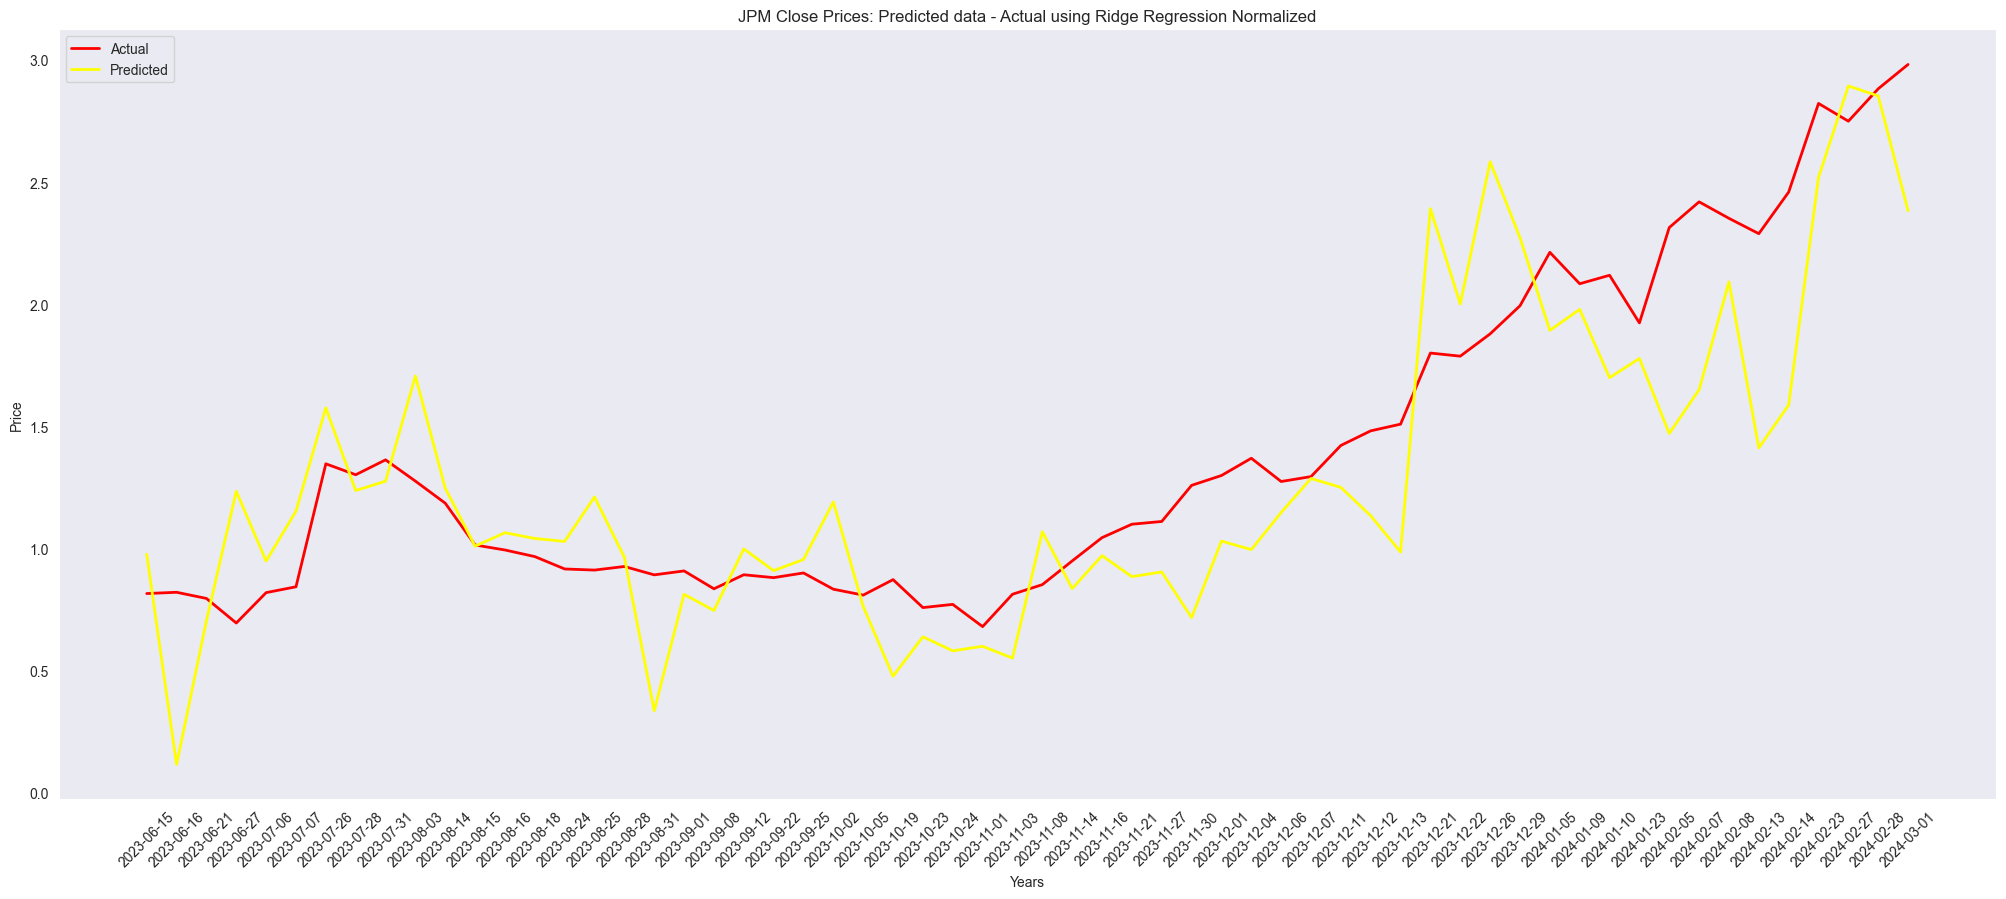

In [51]:
regression_model = {'Ridge Regression Normalized': ridge }
reg_model_metrics(regression_model, X_norm_train, X_norm_val, y_norm_train, y_norm_val)

In [52]:
print_permutation_importance([(ridge,'ridgereg')], X_norm_val, y_norm_val, df_norm, X_norm)

Permutation importance to Close for RidgeCV
MACD_MACD         1.678 +/- 0.104
volume            0.699 +/- 0.046
trade_count       0.542 +/- 0.038
PPO_PPO           0.394 +/- 0.026
TRIX_20_period_TRIX0.358 +/- 0.029
EV_MACD_MACD      0.269 +/- 0.026
MOM_MOM           0.188 +/- 0.012
PPO_HISTO         0.147 +/- 0.016
EV_MACD_SIGNAL    0.099 +/- 0.010
RSI_14_period_RSI 0.092 +/- 0.010
ROC_ROC           0.039 +/- 0.008
HL_PCT            0.026 +/- 0.008
ER_10_period_ER   0.025 +/- 0.005
IFT_RSI_IFT_RSI   0.010 +/- 0.004
PCT_change        0.007 +/- 0.003
news_type         0.000 +/- 0.003
news_score        -0.002 +/- 0.002
 


### Regression Models

In [53]:
poly_degree = get_complexity(X_corr_train, X_corr_val, y_corr_train, y_corr_val, complexity)
poly_ordinal = make_column_transformer((PolynomialFeatures(include_bias=False, degree=poly_degree), make_column_selector(dtype_include=np.number)))

The best degree of the polynomial model is:  2 out of 5
The smallest mean squared error on the test dataset is :  268.2956 out of [336.9012, 268.2956, 499.7811, 2500.8708, 3627.7214]
The best value of the R-sq of the model, as a good fit is:  0.6901 out of [0.6108, 0.6901, 0.4227, -1.8889, -3.1906]


In [54]:
linreg = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_corr_train, y_corr_train)

alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge1 = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge1.fit(X_corr_train, y_corr_train)

lasso = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('lasso_reg', Lasso(alpha=0.01, random_state=42))])
lasso.fit(X_corr_train, y_corr_train)

param_grid = {
    'clf__alpha': [0.1, 1, 10, 0.01],
    'clf__tol': [0.0001, 0.001]
}
pipeline_grid = Pipeline([('transformer', poly_ordinal), ('scaler', MinMaxScaler()), ('clf', HuberRegressor(max_iter=5000))])
grid_search = GridSearchCV(pipeline_grid, param_grid, scoring='r2', cv=10, return_train_score=True, n_jobs=-1)
# Fit the GridSearchCV object to the data
grid_search.fit(X_corr_train, y_corr_train)

rfr = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('rfr', RandomForestRegressor(random_state=0))])
rfr.fit(X_corr_train, y_corr_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027CDC7BB070>)])),
                ('scaler', StandardScaler()),
                ('rfr', RandomForestRegressor(random_state=0))])

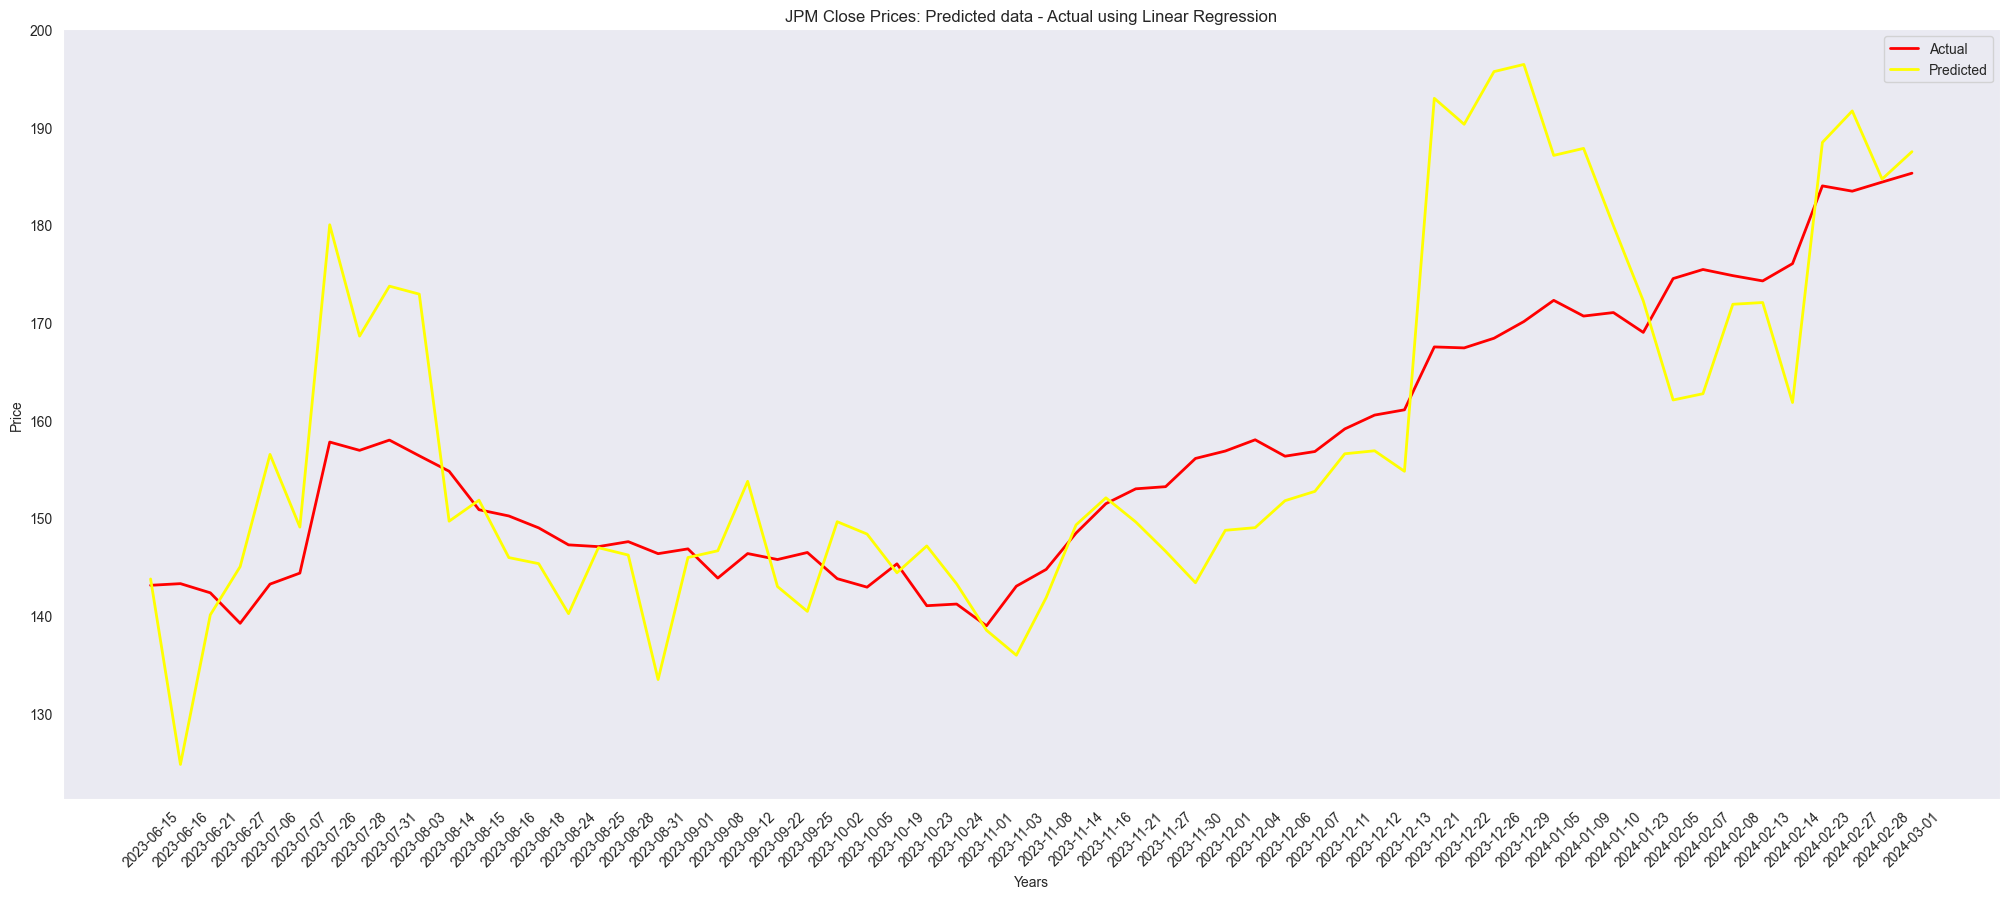

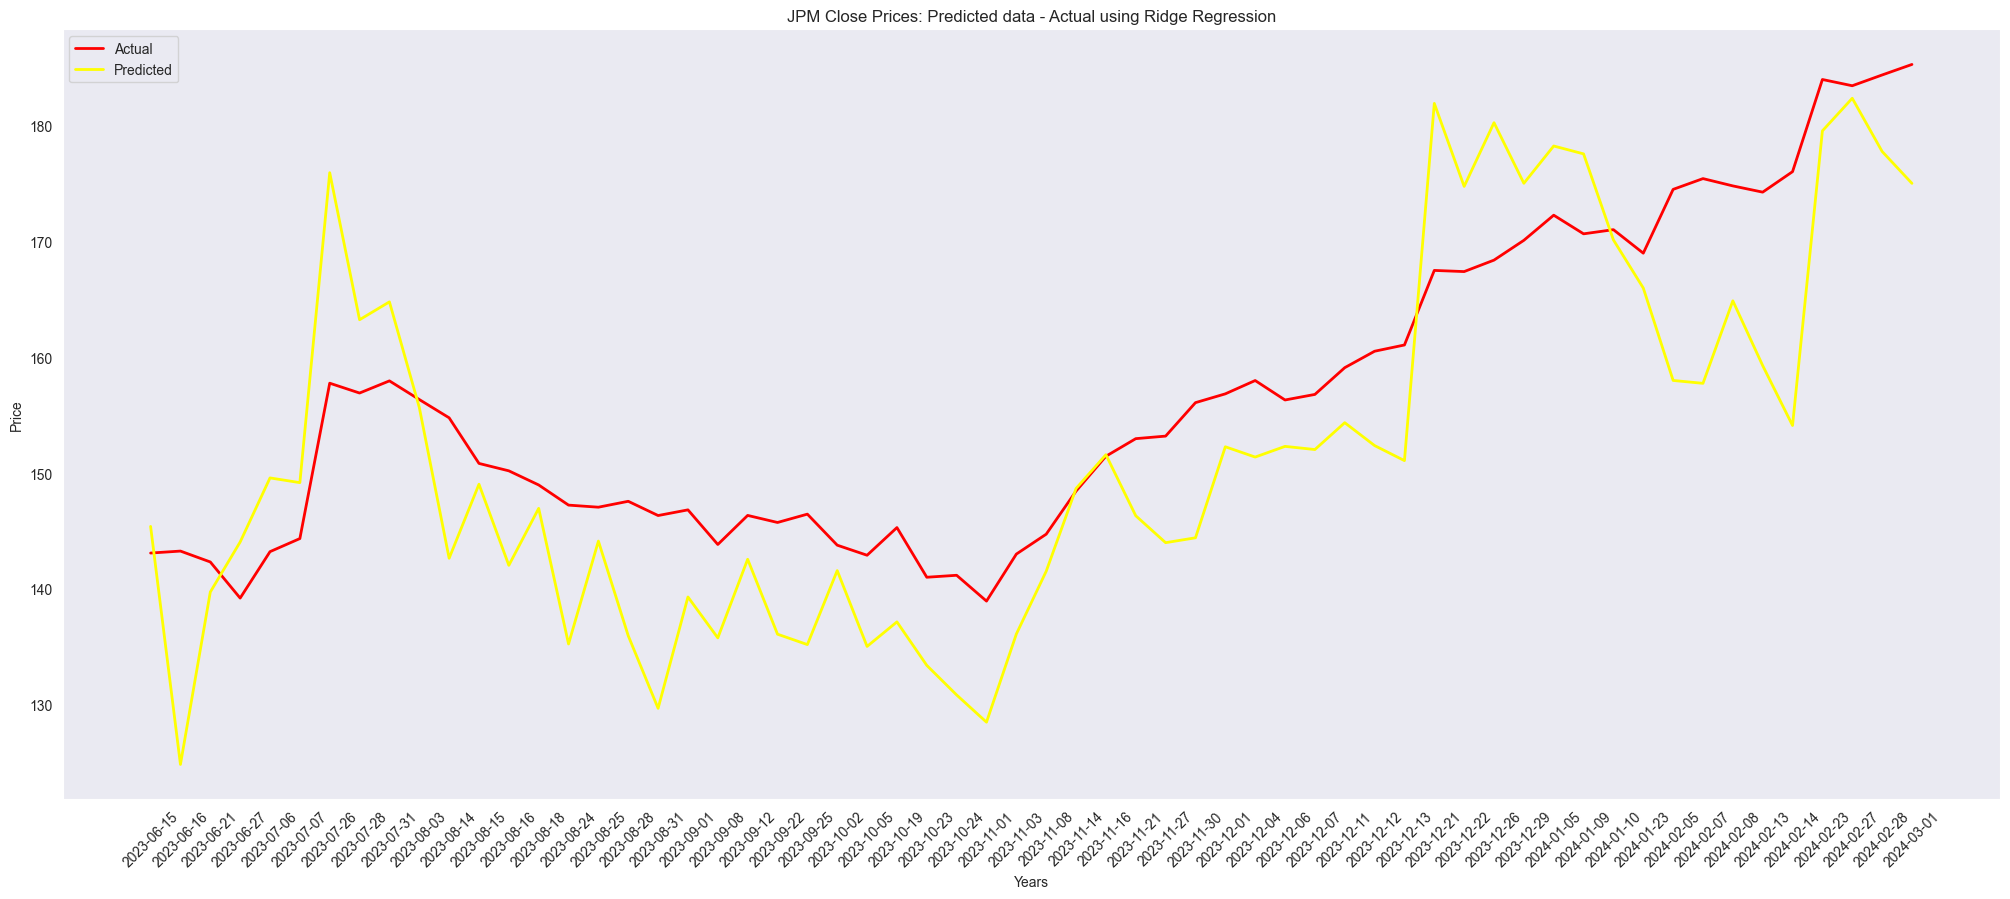

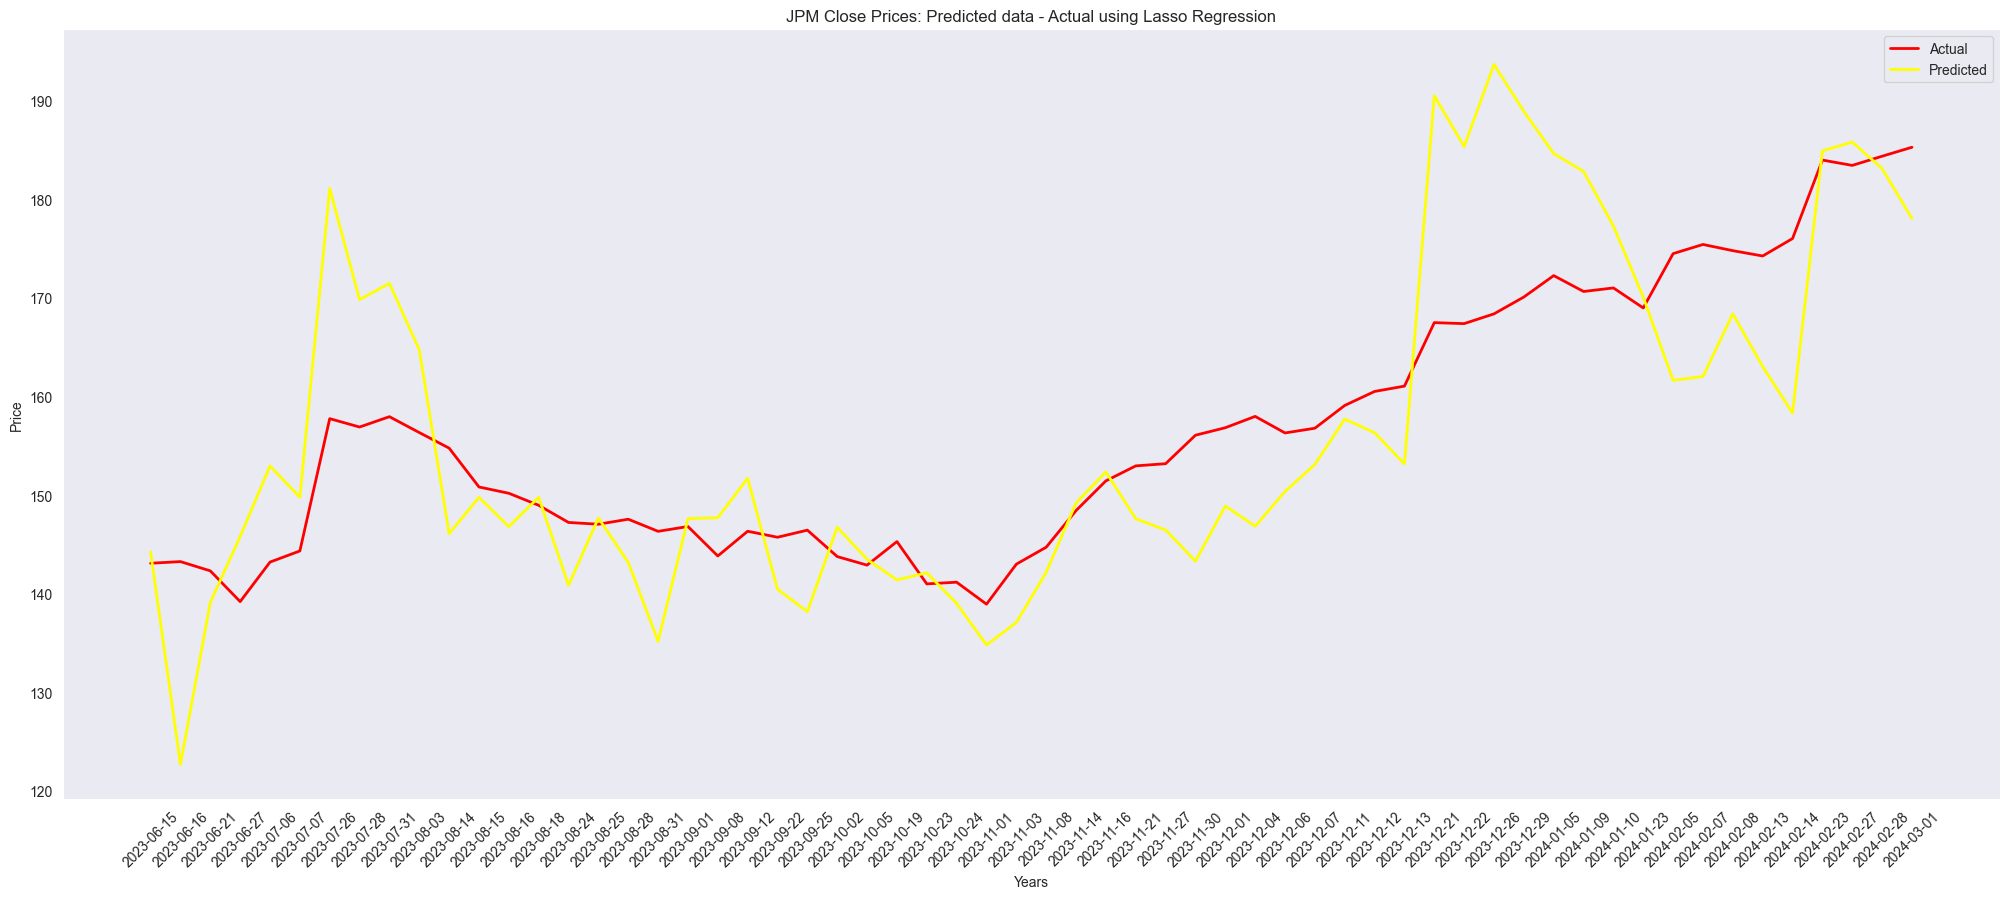

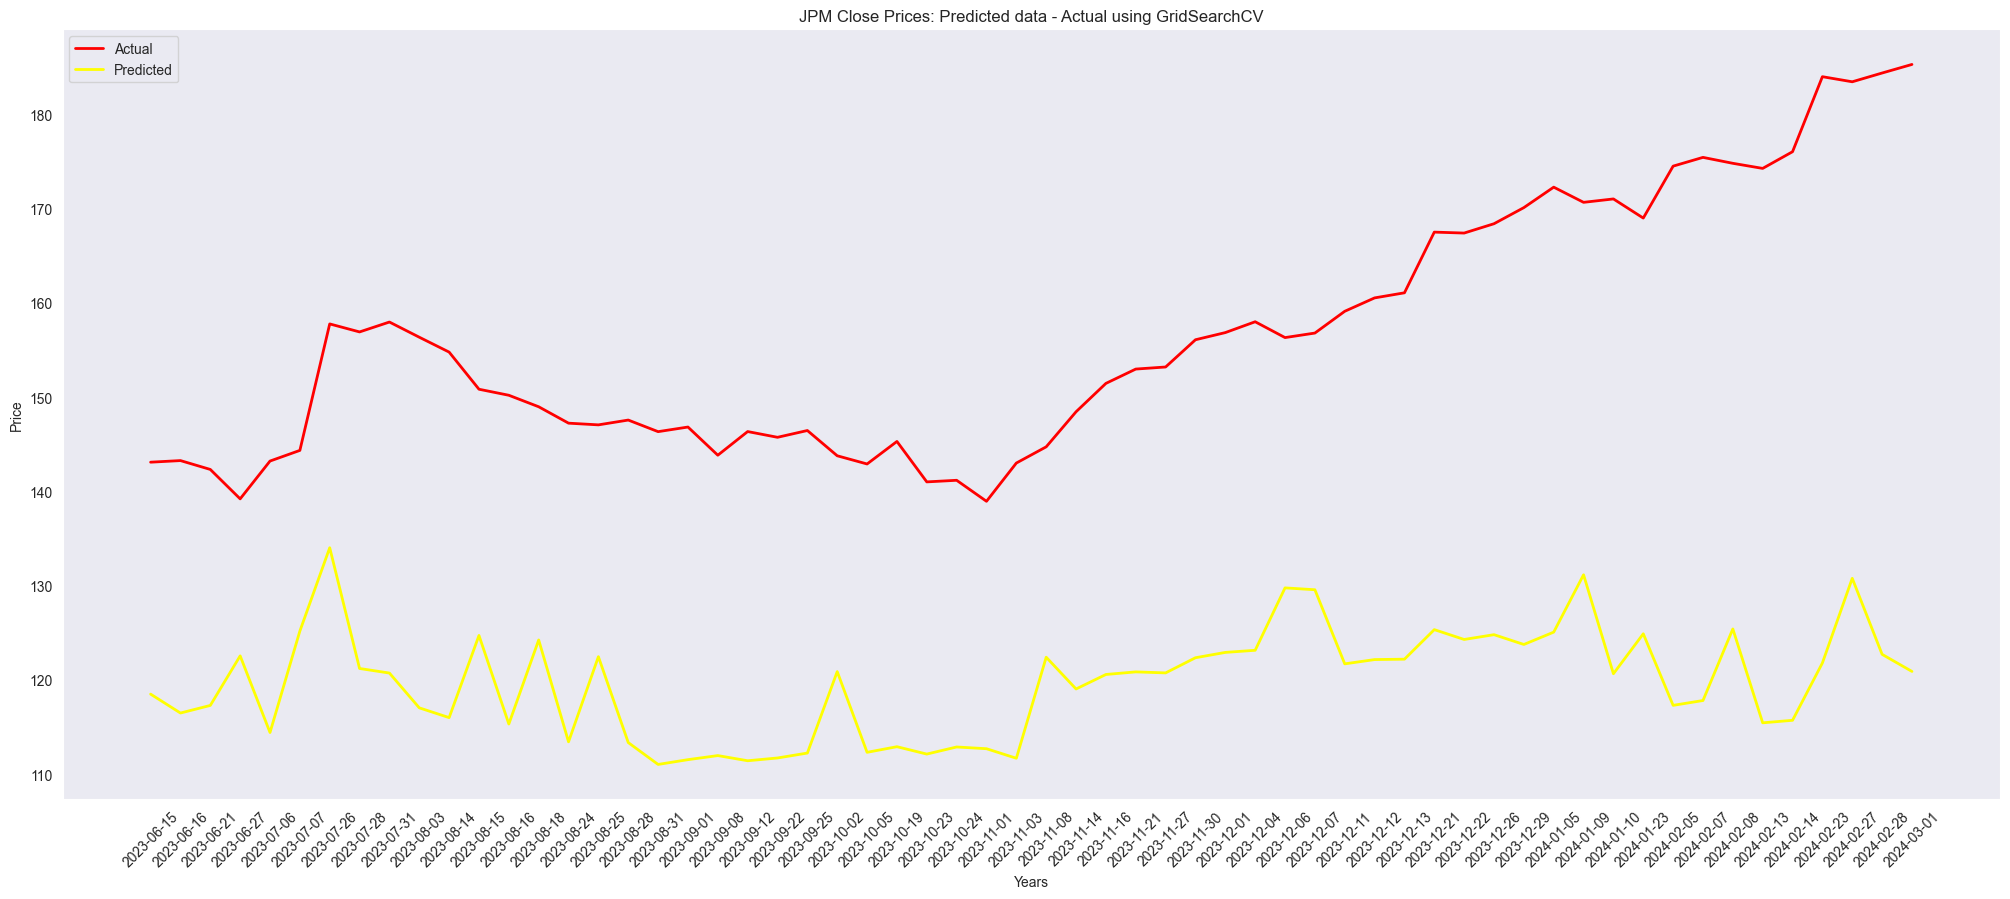

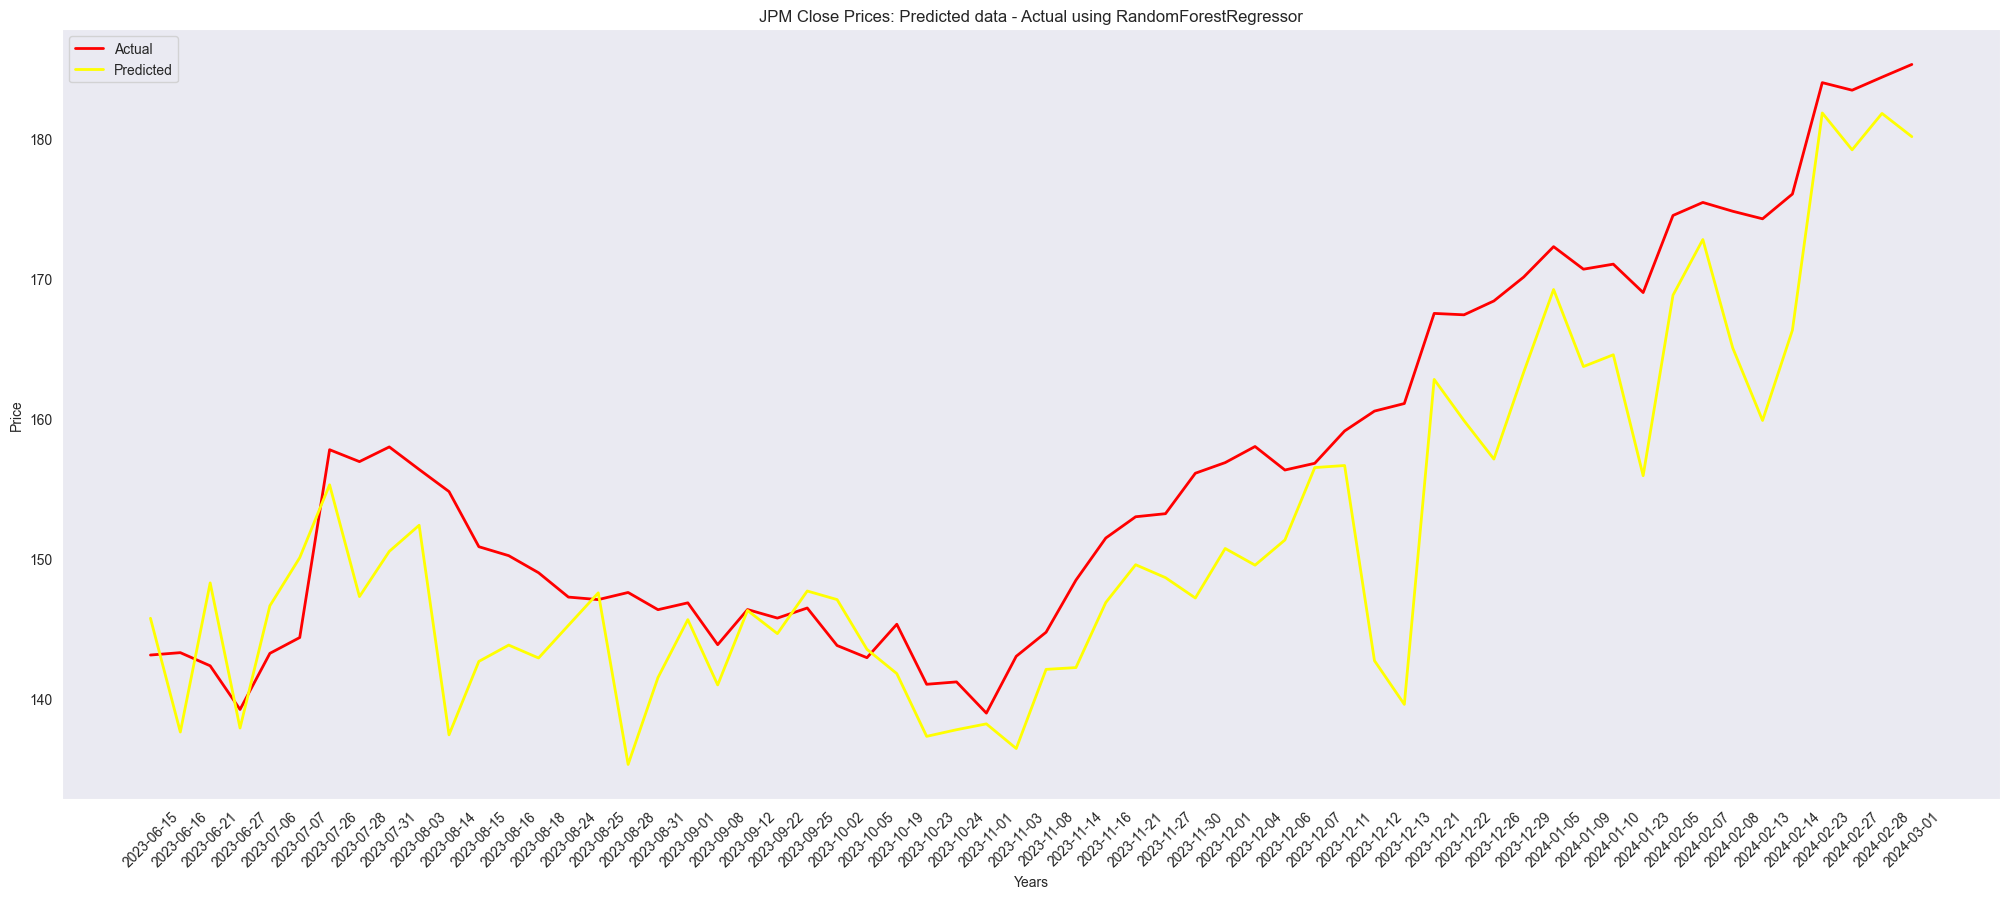

In [55]:
regression_models = {'Linear Regression': linreg,
                     'Ridge Regression': ridge1,
                     'Lasso Regression': lasso,
                     'GridSearchCV': grid_search,
                     'RandomForestRegressor': rfr
                     }
reg_model_metrics(regression_models, X_corr_train, X_corr_val, y_corr_train, y_corr_val)

In [56]:
print_permutation_importance([(linreg,'linreg'), (ridge1,'ridgereg'), (lasso,'lasso_reg'), (grid_search, 'clf'), (rfr,'rfr')], X_corr_val, y_corr_val, df_corr, X_corr)

Permutation importance to Close for LinearRegression
PPO_PPO           24.902 +/- 2.744
MACD_MACD         21.475 +/- 3.029
EV_MACD_MACD      19.245 +/- 3.765
TRIX_20_period_TRIX17.330 +/- 1.773
EV_MACD_SIGNAL    15.489 +/- 2.690
trade_count       1.643 +/- 0.221
MOM_MOM           1.380 +/- 0.201
volume            1.269 +/- 0.122
PPO_HISTO         1.050 +/- 0.220
RSI_14_period_RSI 0.500 +/- 0.062
HL_PCT            0.135 +/- 0.027
ER_10_period_ER   0.104 +/- 0.018
IFT_RSI_IFT_RSI   0.080 +/- 0.011
ROC_ROC           0.067 +/- 0.018
news_score        0.012 +/- 0.057
PCT_change        0.011 +/- 0.005
news_type         -0.011 +/- 0.009
 
Permutation importance to Close for RidgeCV
MACD_MACD         2.636 +/- 0.139
PPO_PPO           2.274 +/- 0.127
trade_count       1.346 +/- 0.104
volume            1.212 +/- 0.084
EV_MACD_MACD      1.052 +/- 0.101
TRIX_20_period_TRIX0.913 +/- 0.080
EV_MACD_SIGNAL    0.786 +/- 0.106
PPO_HISTO         0.483 +/- 0.038
MOM_MOM           0.115 +/- 0.016
HL_PCT   

### LSTM forecasting

In [103]:
df_lstm = df_stocks[['vwap', 'high', 'low', 'close']].copy()

In [104]:
df_lstm.head()

vwap    high    low  close
date                                       
2016-01-04  63.451452  64.060  63.01  63.62
2016-01-05  63.519312  64.130  63.04  63.73
2016-01-06  62.745693  63.125  62.34  62.81
2016-01-07  60.834008  62.000  60.08  60.27
2016-01-08  59.791316  61.270  58.85  58.92

In [105]:
df_lstm.tail()

vwap    high     low   close
date                                          
2024-02-28  184.413387  185.20  182.96  184.38
2024-02-29  185.571020  186.43  183.85  186.06
2024-03-01  185.490087  186.44  185.10  185.29
2024-03-04  186.647544  187.59  184.27  186.68
2024-03-05  188.315997  189.30  186.36  188.55

In [106]:
df_lstm.shape

(2056, 4)

In [107]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(df_lstm) + 1, 1)

In [108]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
HLC_avg = df_lstm[['high', 'low', 'close']].mean(axis=1)
VWAP_avg = df_lstm[['vwap']]
close_val = df_lstm[['close']]

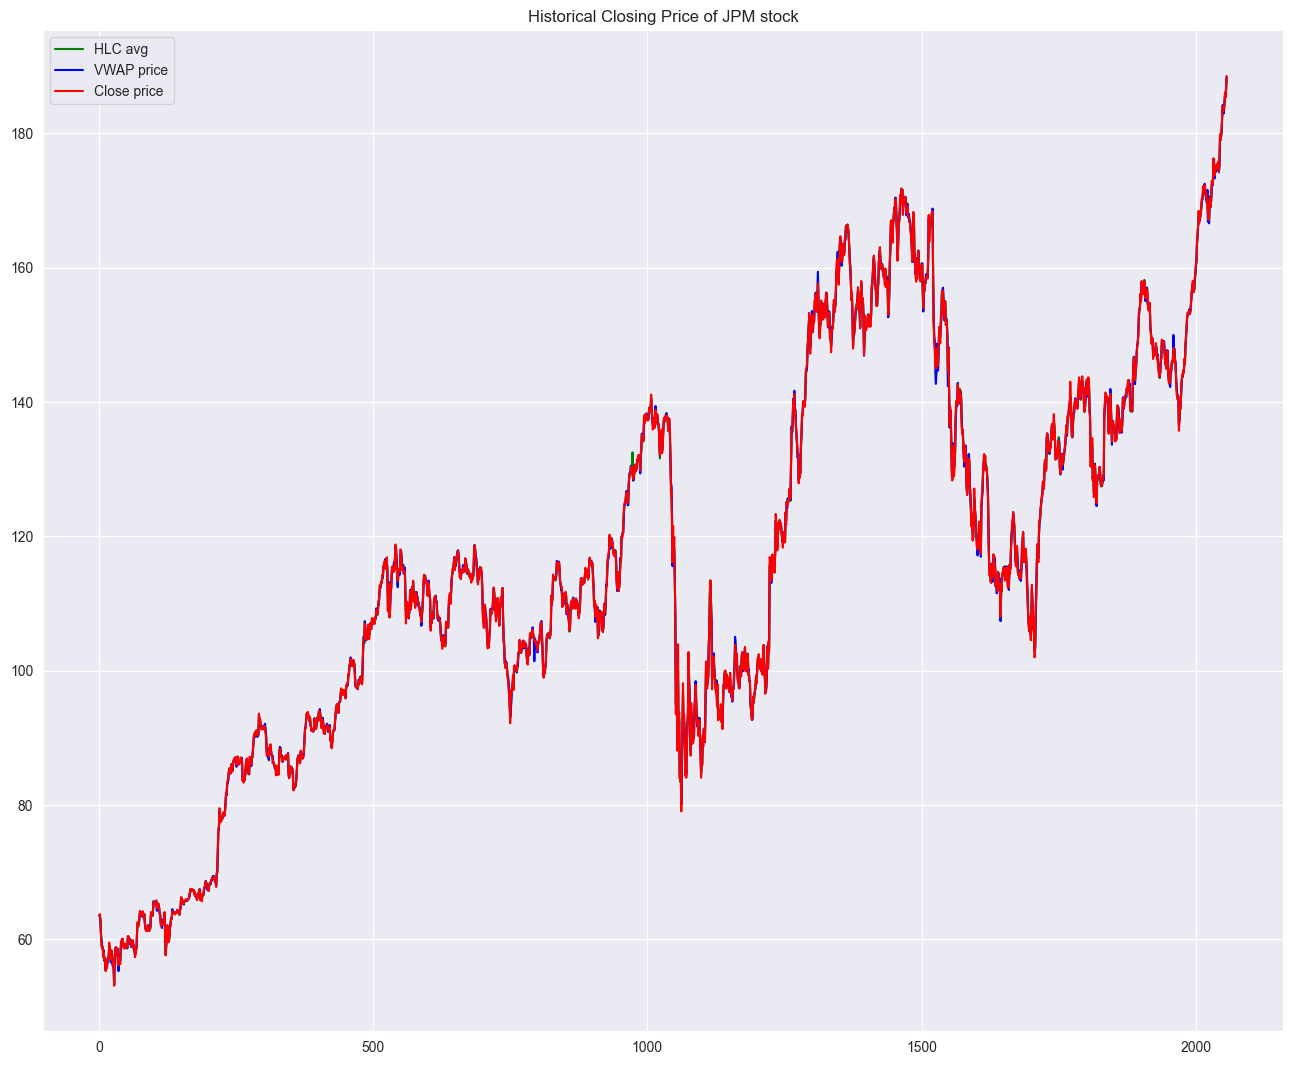

In [109]:
plt.figure(figsize=(16, 13))
plt.plot(obs, HLC_avg, 'g', label='HLC avg')
plt.plot(obs, VWAP_avg, 'b', label='VWAP price')
plt.plot(obs, close_val, 'r', label='Close price')
plt.title('Historical Closing Price of JPM stock')
plt.legend(loc='upper left')
plt.show()

In [110]:
# RESHAPING OF THE DATASET UTIL
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        a = dataset[i:(i + step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [111]:
# PREPARATION OF TIME SERIES DATASET
VWAP_avg = np.reshape(VWAP_avg.values, (len(VWAP_avg), 1))  # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
VWAP_avg = scaler.fit_transform(VWAP_avg)

In [112]:
# TRAIN-TEST SPLIT
train_VWAP = int(len(VWAP_avg) * 0.75)
test_VWAP = len(VWAP_avg) - train_VWAP
train_VWAP, test_VWAP = VWAP_avg[0:train_VWAP, :], VWAP_avg[train_VWAP:len(VWAP_avg), :]

In [113]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
X_train, y_train = new_dataset(train_VWAP, 1)
X_test, y_test = new_dataset(test_VWAP, 1)

In [114]:
# RESHAPING TRAIN AND TEST DATA
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
step_size = 1

In [115]:
# LSTM MODEL
# lstm_model = Sequential()
# lstm_model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
# lstm_model.add(LSTM(16))
# lstm_model.add(Dropout(0.25))
# lstm_model.add(Dense(1))
# lstm_model.add(Activation('linear'))
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
lstm_model.add(LSTM(16))
lstm_model.add(Dense(1))
lstm_model.add(Activation('linear'))

In [116]:
# MODEL COMPILING AND TRAINING
#lstm_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'] )  # Try SGD, adam, adagrad and compare!!!
#fine_tuned_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=1, shuffle=True, verbose=2, validation_data=(X_test, y_test))
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])  # Try SGD, adam, adagrad and compare!!!
lstm_model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
1540/1540 - 3s - 2ms/step - accuracy: 6.4935e-04 - loss: 0.0097 - val_accuracy: 0.0000e+00 - val_loss: 6.0224e-04
Epoch 2/5
1540/1540 - 2s - 1ms/step - accuracy: 6.4935e-04 - loss: 3.2473e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.8017e-04
Epoch 3/5
1540/1540 - 1s - 920us/step - accuracy: 6.4935e-04 - loss: 2.2499e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.1864e-04
Epoch 4/5
1540/1540 - 2s - 994us/step - accuracy: 6.4935e-04 - loss: 2.4166e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.0774e-04
Epoch 5/5
1540/1540 - 2s - 1ms/step - accuracy: 6.4935e-04 - loss: 2.4699e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.0711e-04


In [117]:
# PREDICTION
trainPredict = lstm_model.predict(X_train)
testPredict = lstm_model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


In [118]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [119]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:, 0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.73


In [120]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:, 0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 1.94


In [121]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(VWAP_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict) + step_size, :] = trainPredict

In [122]:
# CREATING SIMILAR DATASET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(VWAP_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (step_size * 2) + 1:len(VWAP_avg) - 1, :] = testPredict

In [123]:
# DE-NORMALIZING MAIN DATASET 
VWAP_avg = scaler.inverse_transform(VWAP_avg)

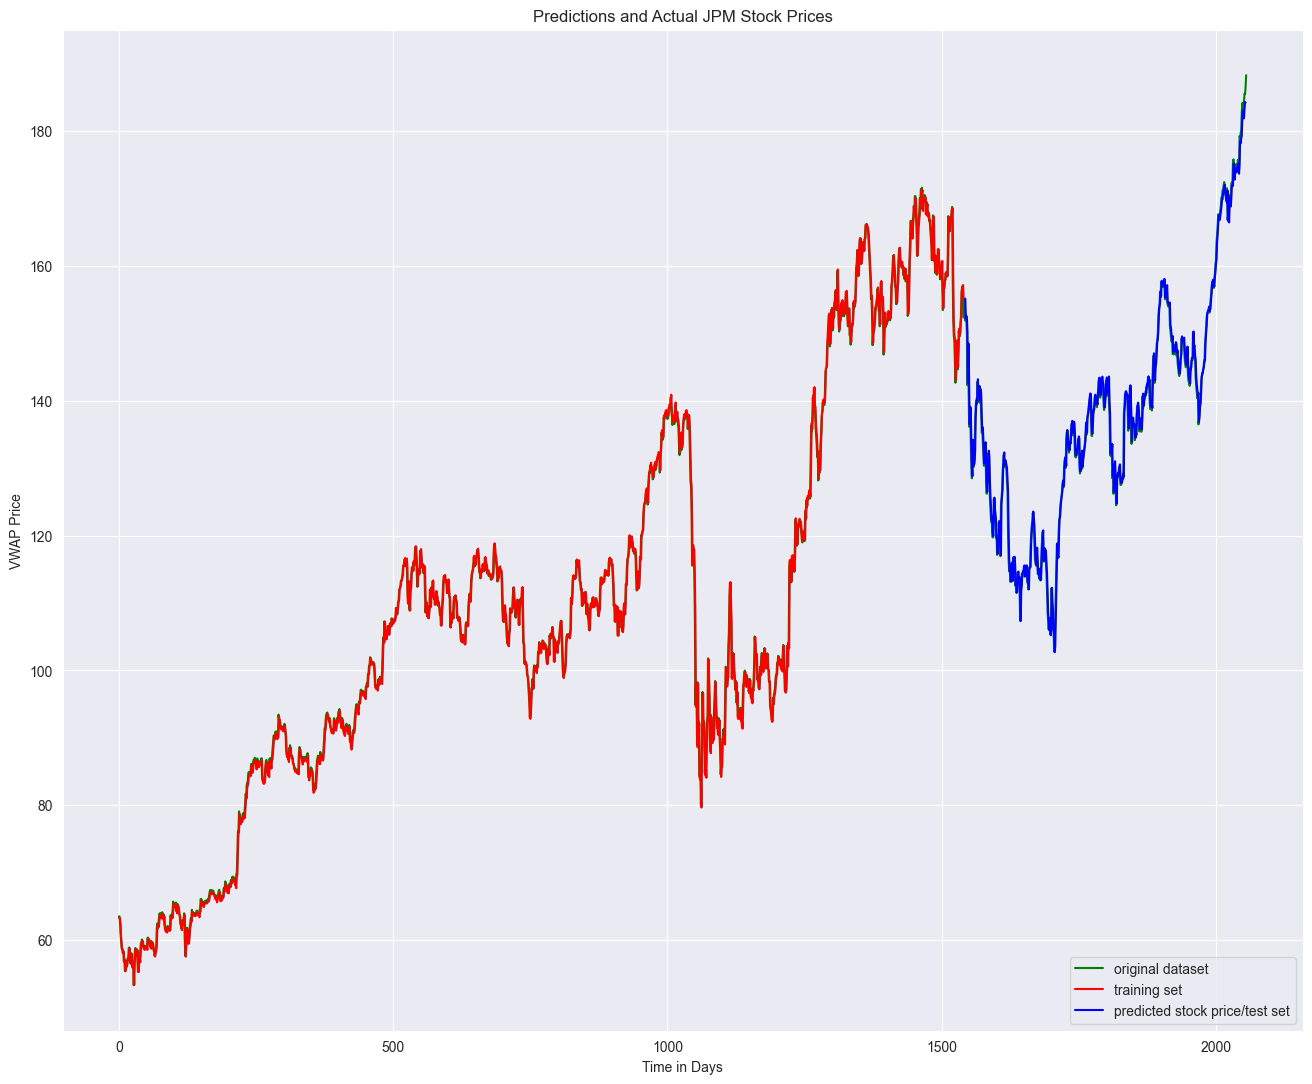

In [124]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(16, 13))
plt.plot(VWAP_avg, 'g', label='original dataset')
plt.plot(trainPredictPlot, 'r', label='training set')
plt.plot(testPredictPlot, 'b', label='predicted stock price/test set')
plt.title('Predictions and Actual JPM Stock Prices', family='Arial', fontsize=12)
plt.legend(loc='lower right')
plt.xlabel('Time in Days')
plt.ylabel('VWAP Price')
plt.show()

In [125]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val / last_val
next_val = lstm_model.predict(np.reshape(last_val_scaled, (1, 1, 1)))
print("Last Day Value:", np.ndarray.item(last_val))
print("Next Day Value:", np.ndarray.item(last_val * next_val))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Last Day Value: 184.25694274902344
Next Day Value: 182.25660705566406
